2025-03-30 13:30:36.387672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-30 13:30:36.387760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-30 13:30:36.389787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 13:30:36.402619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


epoch 0: [time: 1981.9059371948242 ms]
[D loss: 0.6622219085693359 | acc: 53.125] [G loss: 0.6925848722457886]
real


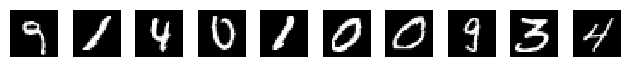

generated


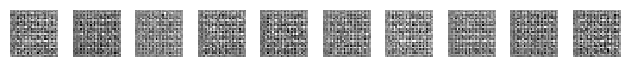

epoch 5: [time: 267.29321479797363 ms]
epoch 10: [time: 278.16009521484375 ms]
epoch 15: [time: 269.90222930908203 ms]
epoch 20: [time: 276.1514186859131 ms]
epoch 25: [time: 278.0137062072754 ms]
epoch 30: [time: 301.21922492980957 ms]
epoch 35: [time: 267.90928840637207 ms]
epoch 40: [time: 289.05415534973145 ms]
epoch 45: [time: 272.2663879394531 ms]
epoch 50: [time: 260.394811630249 ms]
epoch 55: [time: 270.66493034362793 ms]
epoch 60: [time: 275.4852771759033 ms]
epoch 65: [time: 287.71376609802246 ms]
epoch 70: [time: 284.7161293029785 ms]
epoch 75: [time: 274.1355895996094 ms]
epoch 80: [time: 281.49914741516113 ms]
epoch 85: [time: 280.2557945251465 ms]
epoch 90: [time: 276.20553970336914 ms]
epoch 95: [time: 257.59053230285645 ms]
epoch 100: [time: 281.10814094543457 ms]
[D loss: 0.24467519856989384 | acc: 96.875] [G loss: 1.804710865020752]
real


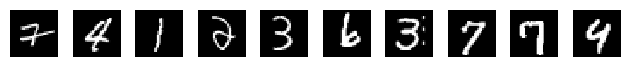

generated


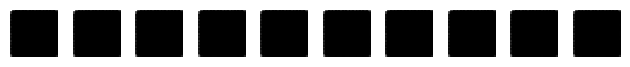

epoch 105: [time: 275.5305767059326 ms]
epoch 110: [time: 258.79430770874023 ms]
epoch 115: [time: 271.7280387878418 ms]
epoch 120: [time: 278.963565826416 ms]
epoch 125: [time: 277.41336822509766 ms]
epoch 130: [time: 279.5116901397705 ms]
epoch 135: [time: 295.3963279724121 ms]
epoch 140: [time: 261.58976554870605 ms]
epoch 145: [time: 266.8273448944092 ms]
epoch 150: [time: 274.6717929840088 ms]
epoch 155: [time: 256.94751739501953 ms]
epoch 160: [time: 248.8231658935547 ms]
epoch 165: [time: 288.70105743408203 ms]
epoch 170: [time: 284.81388092041016 ms]
epoch 175: [time: 253.96990776062012 ms]
epoch 180: [time: 279.32071685791016 ms]
epoch 185: [time: 272.80712127685547 ms]
epoch 190: [time: 281.62479400634766 ms]
epoch 195: [time: 263.43655586242676 ms]
epoch 200: [time: 268.22710037231445 ms]
[D loss: 0.16489335608724787 | acc: 93.75] [G loss: 2.4243040084838867]
real


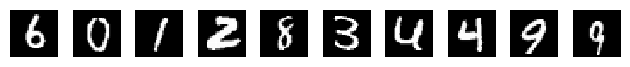

generated


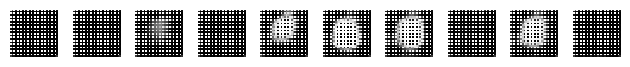

epoch 205: [time: 274.6143341064453 ms]
epoch 210: [time: 276.857852935791 ms]
epoch 215: [time: 263.98587226867676 ms]
epoch 220: [time: 256.8643093109131 ms]
epoch 225: [time: 276.13067626953125 ms]
epoch 230: [time: 268.36538314819336 ms]
epoch 235: [time: 271.67344093322754 ms]
epoch 240: [time: 273.8673686981201 ms]
epoch 245: [time: 264.0244960784912 ms]
epoch 250: [time: 267.2140598297119 ms]
epoch 255: [time: 293.92004013061523 ms]
epoch 260: [time: 268.7854766845703 ms]
epoch 265: [time: 248.9149570465088 ms]
epoch 270: [time: 267.4427032470703 ms]
epoch 275: [time: 269.41919326782227 ms]
epoch 280: [time: 271.2664604187012 ms]
epoch 285: [time: 264.8458480834961 ms]
epoch 290: [time: 278.5818576812744 ms]
epoch 295: [time: 278.52344512939453 ms]
epoch 300: [time: 275.2537727355957 ms]
[D loss: 0.07204660028235935 | acc: 99.21875] [G loss: 4.04948616027832]
real


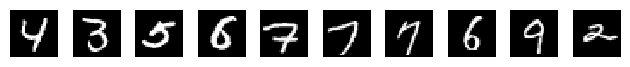

generated


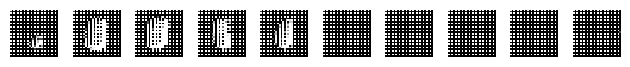

epoch 305: [time: 275.1483917236328 ms]
epoch 310: [time: 254.7628879547119 ms]
epoch 315: [time: 266.02625846862793 ms]
epoch 320: [time: 275.3136157989502 ms]
epoch 325: [time: 278.11408042907715 ms]
epoch 330: [time: 259.8412036895752 ms]
epoch 335: [time: 274.3420600891113 ms]
epoch 340: [time: 277.9231071472168 ms]
epoch 345: [time: 275.7406234741211 ms]
epoch 350: [time: 272.0963954925537 ms]
epoch 355: [time: 282.1371555328369 ms]
epoch 360: [time: 270.1585292816162 ms]
epoch 365: [time: 262.9895210266113 ms]
epoch 370: [time: 253.3566951751709 ms]
epoch 375: [time: 267.75360107421875 ms]
epoch 380: [time: 279.63995933532715 ms]
epoch 385: [time: 278.06711196899414 ms]
epoch 390: [time: 276.26729011535645 ms]
epoch 395: [time: 268.0187225341797 ms]
epoch 400: [time: 287.88256645202637 ms]
[D loss: 0.297985702753067 | acc: 89.0625] [G loss: 2.054086685180664]
real


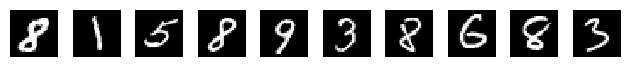

generated


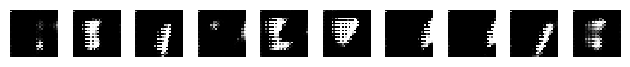

epoch 405: [time: 270.32923698425293 ms]
epoch 410: [time: 286.6690158843994 ms]
epoch 415: [time: 282.58728981018066 ms]
epoch 420: [time: 286.38458251953125 ms]
epoch 425: [time: 279.56628799438477 ms]
epoch 430: [time: 281.62288665771484 ms]
epoch 435: [time: 278.3854007720947 ms]
epoch 440: [time: 263.93938064575195 ms]
epoch 445: [time: 283.17737579345703 ms]
epoch 450: [time: 274.6562957763672 ms]
epoch 455: [time: 270.8146572113037 ms]
epoch 460: [time: 274.8839855194092 ms]
epoch 465: [time: 274.3189334869385 ms]
epoch 470: [time: 275.58016777038574 ms]
epoch 475: [time: 294.32153701782227 ms]
epoch 480: [time: 293.49303245544434 ms]
epoch 485: [time: 278.97047996520996 ms]
epoch 490: [time: 281.25882148742676 ms]
epoch 495: [time: 272.7198600769043 ms]
epoch 500: [time: 284.0449810028076 ms]
[D loss: 0.29495060071349144 | acc: 84.375] [G loss: 2.5264415740966797]
real


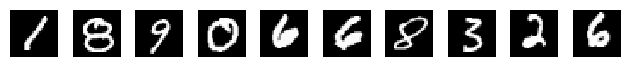

generated


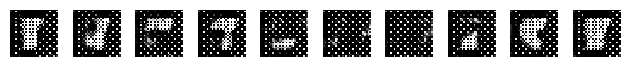

epoch 505: [time: 268.4304714202881 ms]
epoch 510: [time: 295.93539237976074 ms]
epoch 515: [time: 291.05472564697266 ms]
epoch 520: [time: 283.3847999572754 ms]
epoch 525: [time: 274.80363845825195 ms]
epoch 530: [time: 277.7678966522217 ms]
epoch 535: [time: 273.30946922302246 ms]
epoch 540: [time: 289.3860340118408 ms]
epoch 545: [time: 289.87717628479004 ms]
epoch 550: [time: 280.712366104126 ms]
epoch 555: [time: 284.2268943786621 ms]
epoch 560: [time: 280.08365631103516 ms]
epoch 565: [time: 296.62466049194336 ms]
epoch 570: [time: 288.4385585784912 ms]
epoch 575: [time: 264.8301124572754 ms]
epoch 580: [time: 282.7038764953613 ms]
epoch 585: [time: 275.5389213562012 ms]
epoch 590: [time: 280.17568588256836 ms]
epoch 595: [time: 268.95856857299805 ms]
epoch 600: [time: 279.8118591308594 ms]
[D loss: 0.544508121907711 | acc: 75.78125] [G loss: 1.8362793922424316]
real


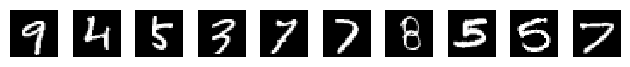

generated


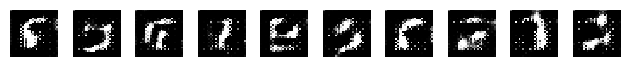

epoch 605: [time: 270.71428298950195 ms]
epoch 610: [time: 279.24108505249023 ms]
epoch 615: [time: 280.0779342651367 ms]
epoch 620: [time: 287.5092029571533 ms]
epoch 625: [time: 273.2582092285156 ms]
epoch 630: [time: 286.27586364746094 ms]
epoch 635: [time: 277.6210308074951 ms]
epoch 640: [time: 274.3675708770752 ms]
epoch 645: [time: 276.0469913482666 ms]
epoch 650: [time: 270.4470157623291 ms]
epoch 655: [time: 317.9357051849365 ms]
epoch 660: [time: 276.4098644256592 ms]
epoch 665: [time: 271.63004875183105 ms]
epoch 670: [time: 285.37440299987793 ms]
epoch 675: [time: 270.75743675231934 ms]
epoch 680: [time: 278.3966064453125 ms]
epoch 685: [time: 280.47657012939453 ms]
epoch 690: [time: 268.8124179840088 ms]
epoch 695: [time: 274.6307849884033 ms]
epoch 700: [time: 268.22662353515625 ms]
[D loss: 0.6239801645278931 | acc: 66.40625] [G loss: 2.388899803161621]
real


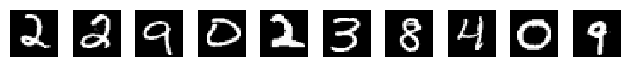

generated


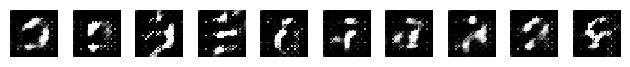

epoch 705: [time: 272.12071418762207 ms]
epoch 710: [time: 268.16844940185547 ms]
epoch 715: [time: 281.79216384887695 ms]
epoch 720: [time: 287.2309684753418 ms]
epoch 725: [time: 274.0144729614258 ms]
epoch 730: [time: 270.7078456878662 ms]
epoch 735: [time: 271.99816703796387 ms]
epoch 740: [time: 280.90620040893555 ms]
epoch 745: [time: 270.02573013305664 ms]
epoch 750: [time: 262.2356414794922 ms]
epoch 755: [time: 276.92461013793945 ms]
epoch 760: [time: 273.93531799316406 ms]
epoch 765: [time: 273.7104892730713 ms]
epoch 770: [time: 265.03753662109375 ms]
epoch 775: [time: 267.09938049316406 ms]
epoch 780: [time: 267.5042152404785 ms]
epoch 785: [time: 266.8132781982422 ms]
epoch 790: [time: 284.77025032043457 ms]
epoch 795: [time: 260.2663040161133 ms]
epoch 800: [time: 331.1014175415039 ms]
[D loss: 0.8544886857271194 | acc: 53.90625] [G loss: 1.9524564743041992]
real


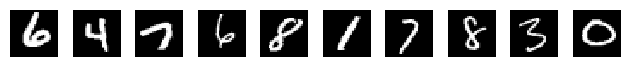

generated


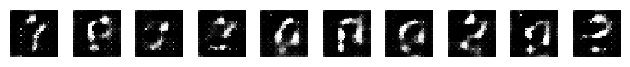

epoch 805: [time: 278.78475189208984 ms]
epoch 810: [time: 277.4684429168701 ms]
epoch 815: [time: 280.47704696655273 ms]
epoch 820: [time: 282.36937522888184 ms]
epoch 825: [time: 261.4743709564209 ms]
epoch 830: [time: 269.9432373046875 ms]
epoch 835: [time: 273.6072540283203 ms]
epoch 840: [time: 272.63951301574707 ms]
epoch 845: [time: 262.9578113555908 ms]
epoch 850: [time: 277.9409885406494 ms]
epoch 855: [time: 278.46384048461914 ms]
epoch 860: [time: 286.78202629089355 ms]
epoch 865: [time: 271.8508243560791 ms]
epoch 870: [time: 271.37279510498047 ms]
epoch 875: [time: 283.6341857910156 ms]
epoch 880: [time: 270.17974853515625 ms]
epoch 885: [time: 272.6471424102783 ms]
epoch 890: [time: 280.8361053466797 ms]
epoch 895: [time: 279.2351245880127 ms]
epoch 900: [time: 254.27722930908203 ms]
[D loss: 1.0394175946712494 | acc: 48.4375] [G loss: 1.7691408395767212]
real


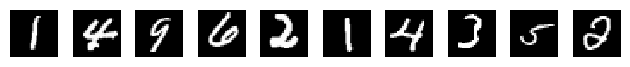

generated


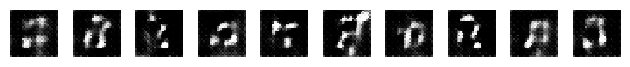

epoch 905: [time: 274.01137351989746 ms]
epoch 910: [time: 285.3052616119385 ms]
epoch 915: [time: 279.9086570739746 ms]
epoch 920: [time: 278.627872467041 ms]
epoch 925: [time: 261.69872283935547 ms]
epoch 930: [time: 270.2593803405762 ms]
epoch 935: [time: 277.24313735961914 ms]
epoch 940: [time: 290.4543876647949 ms]
epoch 945: [time: 289.247989654541 ms]
epoch 950: [time: 280.3769111633301 ms]
epoch 955: [time: 272.83763885498047 ms]
epoch 960: [time: 296.0085868835449 ms]
epoch 965: [time: 294.3086624145508 ms]
epoch 970: [time: 267.78697967529297 ms]
epoch 975: [time: 284.6815586090088 ms]
epoch 980: [time: 270.45345306396484 ms]
epoch 985: [time: 287.325382232666 ms]
epoch 990: [time: 266.434907913208 ms]
epoch 995: [time: 296.21005058288574 ms]
epoch 1000: [time: 308.05206298828125 ms]
[D loss: 0.7317350134253502 | acc: 67.1875] [G loss: 1.6111516952514648]
real


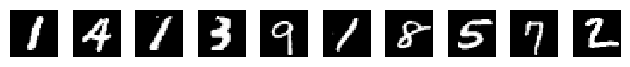

generated


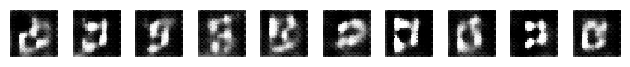

epoch 1005: [time: 285.08925437927246 ms]
epoch 1010: [time: 351.38821601867676 ms]
epoch 1015: [time: 275.7229804992676 ms]
epoch 1020: [time: 289.1247272491455 ms]
epoch 1025: [time: 312.00361251831055 ms]
epoch 1030: [time: 274.89304542541504 ms]
epoch 1035: [time: 283.5278511047363 ms]
epoch 1040: [time: 265.90609550476074 ms]
epoch 1045: [time: 258.38232040405273 ms]
epoch 1050: [time: 276.94082260131836 ms]
epoch 1055: [time: 264.96171951293945 ms]
epoch 1060: [time: 286.23151779174805 ms]
epoch 1065: [time: 272.17650413513184 ms]
epoch 1070: [time: 281.91447257995605 ms]
epoch 1075: [time: 258.3599090576172 ms]
epoch 1080: [time: 276.08489990234375 ms]
epoch 1085: [time: 278.06806564331055 ms]
epoch 1090: [time: 275.7260799407959 ms]
epoch 1095: [time: 298.37846755981445 ms]
epoch 1100: [time: 276.3993740081787 ms]
[D loss: 1.3521073162555695 | acc: 48.4375] [G loss: 1.4679120779037476]
real


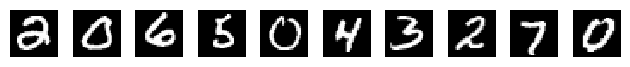

generated


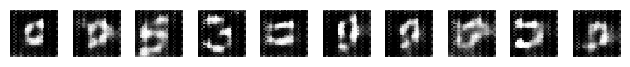

epoch 1105: [time: 287.8096103668213 ms]
epoch 1110: [time: 300.062894821167 ms]
epoch 1115: [time: 268.4192657470703 ms]
epoch 1120: [time: 281.98790550231934 ms]
epoch 1125: [time: 270.6878185272217 ms]
epoch 1130: [time: 289.63446617126465 ms]
epoch 1135: [time: 310.0779056549072 ms]
epoch 1140: [time: 281.3985347747803 ms]
epoch 1145: [time: 290.6203269958496 ms]
epoch 1150: [time: 283.96105766296387 ms]
epoch 1155: [time: 272.84955978393555 ms]
epoch 1160: [time: 284.47937965393066 ms]
epoch 1165: [time: 276.2787342071533 ms]
epoch 1170: [time: 292.0958995819092 ms]
epoch 1175: [time: 280.49349784851074 ms]
epoch 1180: [time: 286.1943244934082 ms]
epoch 1185: [time: 267.0412063598633 ms]
epoch 1190: [time: 299.6652126312256 ms]
epoch 1195: [time: 277.7836322784424 ms]
epoch 1200: [time: 290.4052734375 ms]
[D loss: 1.2613824605941772 | acc: 57.03125] [G loss: 2.4996824264526367]
real


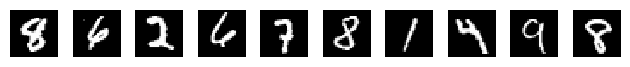

generated


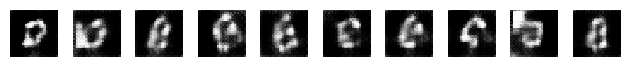

epoch 1205: [time: 268.4457302093506 ms]
epoch 1210: [time: 262.6824378967285 ms]
epoch 1215: [time: 323.29535484313965 ms]
epoch 1220: [time: 271.3305950164795 ms]
epoch 1225: [time: 281.4669609069824 ms]
epoch 1230: [time: 261.80171966552734 ms]
epoch 1235: [time: 385.6017589569092 ms]
epoch 1240: [time: 267.40241050720215 ms]
epoch 1245: [time: 278.34367752075195 ms]
epoch 1250: [time: 287.80055046081543 ms]
epoch 1255: [time: 284.6944332122803 ms]
epoch 1260: [time: 276.0357856750488 ms]
epoch 1265: [time: 274.0745544433594 ms]
epoch 1270: [time: 284.39927101135254 ms]
epoch 1275: [time: 274.6467590332031 ms]
epoch 1280: [time: 277.118444442749 ms]
epoch 1285: [time: 290.1806831359863 ms]
epoch 1290: [time: 277.1017551422119 ms]
epoch 1295: [time: 272.11713790893555 ms]
epoch 1300: [time: 272.20749855041504 ms]
[D loss: 1.5027440339326859 | acc: 57.03125] [G loss: 2.8363521099090576]
real


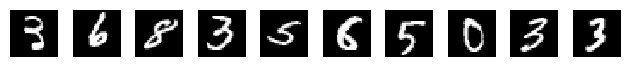

generated


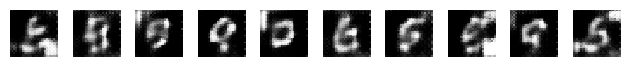

epoch 1305: [time: 274.7530937194824 ms]
epoch 1310: [time: 292.6909923553467 ms]
epoch 1315: [time: 277.76551246643066 ms]
epoch 1320: [time: 271.82722091674805 ms]
epoch 1325: [time: 264.83869552612305 ms]
epoch 1330: [time: 263.9913558959961 ms]
epoch 1335: [time: 287.9490852355957 ms]
epoch 1340: [time: 282.84311294555664 ms]
epoch 1345: [time: 278.6409854888916 ms]
epoch 1350: [time: 277.62889862060547 ms]
epoch 1355: [time: 265.63549041748047 ms]
epoch 1360: [time: 279.6647548675537 ms]
epoch 1365: [time: 272.716760635376 ms]
epoch 1370: [time: 275.8216857910156 ms]
epoch 1375: [time: 269.29235458374023 ms]
epoch 1380: [time: 283.05888175964355 ms]
epoch 1385: [time: 298.33102226257324 ms]
epoch 1390: [time: 297.32465744018555 ms]
epoch 1395: [time: 275.84171295166016 ms]
epoch 1400: [time: 281.4793586730957 ms]
[D loss: 0.9291351847350597 | acc: 66.40625] [G loss: 2.953244209289551]
real


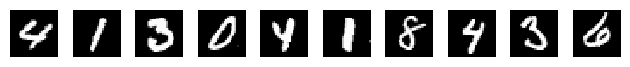

generated


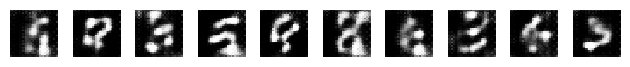

epoch 1405: [time: 289.5214557647705 ms]
epoch 1410: [time: 282.4118137359619 ms]
epoch 1415: [time: 267.0142650604248 ms]
epoch 1420: [time: 258.9714527130127 ms]
epoch 1425: [time: 276.02124214172363 ms]
epoch 1430: [time: 266.24417304992676 ms]
epoch 1435: [time: 285.76183319091797 ms]
epoch 1440: [time: 271.6958522796631 ms]
epoch 1445: [time: 291.80431365966797 ms]
epoch 1450: [time: 280.18832206726074 ms]
epoch 1455: [time: 264.5227909088135 ms]
epoch 1460: [time: 270.52903175354004 ms]
epoch 1465: [time: 263.70859146118164 ms]
epoch 1470: [time: 387.06207275390625 ms]
epoch 1475: [time: 270.5206871032715 ms]
epoch 1480: [time: 267.26317405700684 ms]
epoch 1485: [time: 280.9154987335205 ms]
epoch 1490: [time: 271.5756893157959 ms]
epoch 1495: [time: 262.941837310791 ms]
epoch 1500: [time: 277.7731418609619 ms]
[D loss: 1.509283922612667 | acc: 57.03125] [G loss: 2.7944047451019287]
real


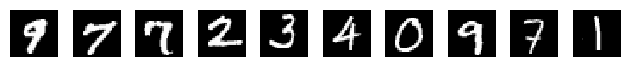

generated


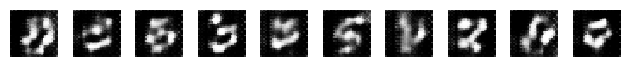

epoch 1505: [time: 267.1937942504883 ms]
epoch 1510: [time: 290.1475429534912 ms]
epoch 1515: [time: 272.6426124572754 ms]
epoch 1520: [time: 297.6973056793213 ms]
epoch 1525: [time: 263.90886306762695 ms]
epoch 1530: [time: 267.7111625671387 ms]
epoch 1535: [time: 282.8714847564697 ms]
epoch 1540: [time: 391.5443420410156 ms]
epoch 1545: [time: 273.07629585266113 ms]
epoch 1550: [time: 271.47865295410156 ms]
epoch 1555: [time: 275.22921562194824 ms]
epoch 1560: [time: 274.80340003967285 ms]
epoch 1565: [time: 293.24793815612793 ms]
epoch 1570: [time: 276.3864994049072 ms]
epoch 1575: [time: 299.64637756347656 ms]
epoch 1580: [time: 296.4150905609131 ms]
epoch 1585: [time: 282.59778022766113 ms]
epoch 1590: [time: 271.71897888183594 ms]
epoch 1595: [time: 280.7579040527344 ms]
epoch 1600: [time: 290.62676429748535 ms]
[D loss: 2.0419084429740906 | acc: 53.90625] [G loss: 2.2526352405548096]
real


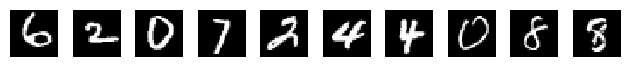

generated


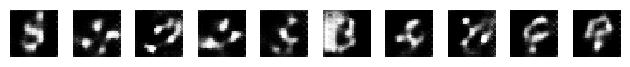

epoch 1605: [time: 388.5316848754883 ms]
epoch 1610: [time: 272.72772789001465 ms]
epoch 1615: [time: 275.81167221069336 ms]
epoch 1620: [time: 274.74355697631836 ms]
epoch 1625: [time: 261.26766204833984 ms]
epoch 1630: [time: 267.56739616394043 ms]
epoch 1635: [time: 335.39819717407227 ms]
epoch 1640: [time: 276.17430686950684 ms]
epoch 1645: [time: 286.5176200866699 ms]
epoch 1650: [time: 263.9310359954834 ms]
epoch 1655: [time: 309.70311164855957 ms]
epoch 1660: [time: 277.209997177124 ms]
epoch 1665: [time: 261.0158920288086 ms]
epoch 1670: [time: 273.0891704559326 ms]
epoch 1675: [time: 273.4208106994629 ms]
epoch 1680: [time: 277.8148651123047 ms]
epoch 1685: [time: 278.82885932922363 ms]
epoch 1690: [time: 264.1885280609131 ms]
epoch 1695: [time: 284.6403121948242 ms]
epoch 1700: [time: 266.8192386627197 ms]
[D loss: 1.8026321530342102 | acc: 51.5625] [G loss: 2.3174266815185547]
real


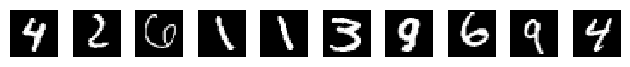

generated


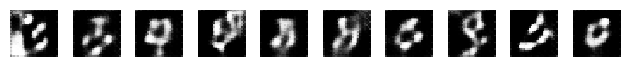

epoch 1705: [time: 273.57959747314453 ms]
epoch 1710: [time: 294.45552825927734 ms]
epoch 1715: [time: 273.42867851257324 ms]
epoch 1720: [time: 274.51443672180176 ms]
epoch 1725: [time: 270.00927925109863 ms]
epoch 1730: [time: 267.95268058776855 ms]
epoch 1735: [time: 266.91603660583496 ms]
epoch 1740: [time: 284.58404541015625 ms]
epoch 1745: [time: 378.25989723205566 ms]
epoch 1750: [time: 273.00548553466797 ms]
epoch 1755: [time: 278.8240909576416 ms]
epoch 1760: [time: 290.62366485595703 ms]
epoch 1765: [time: 272.14741706848145 ms]
epoch 1770: [time: 263.3242607116699 ms]
epoch 1775: [time: 268.3558464050293 ms]
epoch 1780: [time: 264.56308364868164 ms]
epoch 1785: [time: 280.77149391174316 ms]
epoch 1790: [time: 276.9200801849365 ms]
epoch 1795: [time: 282.93371200561523 ms]
epoch 1800: [time: 270.1082229614258 ms]
[D loss: 2.321457713842392 | acc: 57.03125] [G loss: 2.8215343952178955]
real


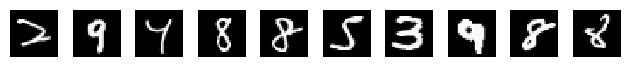

generated


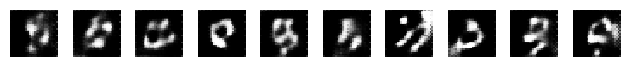

epoch 1805: [time: 298.42257499694824 ms]
epoch 1810: [time: 403.89132499694824 ms]
epoch 1815: [time: 276.5984535217285 ms]
epoch 1820: [time: 264.16826248168945 ms]
epoch 1825: [time: 287.6620292663574 ms]
epoch 1830: [time: 284.23285484313965 ms]
epoch 1835: [time: 281.85129165649414 ms]
epoch 1840: [time: 282.45019912719727 ms]
epoch 1845: [time: 440.5689239501953 ms]
epoch 1850: [time: 283.43963623046875 ms]
epoch 1855: [time: 271.67344093322754 ms]
epoch 1860: [time: 277.71925926208496 ms]
epoch 1865: [time: 274.4605541229248 ms]
epoch 1870: [time: 273.60081672668457 ms]
epoch 1875: [time: 265.7618522644043 ms]
epoch 1880: [time: 263.43774795532227 ms]
epoch 1885: [time: 273.65779876708984 ms]
epoch 1890: [time: 282.09590911865234 ms]
epoch 1895: [time: 284.41524505615234 ms]
epoch 1900: [time: 285.94088554382324 ms]
[D loss: 1.9861761629581451 | acc: 57.8125] [G loss: 2.752960205078125]
real


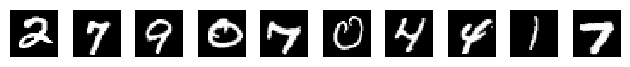

generated


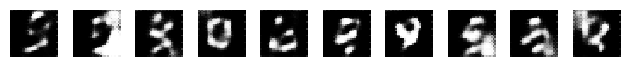

epoch 1905: [time: 275.0201225280762 ms]
epoch 1910: [time: 275.91729164123535 ms]
epoch 1915: [time: 402.7259349822998 ms]
epoch 1920: [time: 277.6761054992676 ms]
epoch 1925: [time: 284.4195365905762 ms]
epoch 1930: [time: 277.0533561706543 ms]
epoch 1935: [time: 278.1329154968262 ms]
epoch 1940: [time: 264.94789123535156 ms]
epoch 1945: [time: 285.7537269592285 ms]
epoch 1950: [time: 392.14420318603516 ms]
epoch 1955: [time: 286.8506908416748 ms]
epoch 1960: [time: 285.92586517333984 ms]
epoch 1965: [time: 286.3624095916748 ms]
epoch 1970: [time: 291.21851921081543 ms]
epoch 1975: [time: 266.5424346923828 ms]
epoch 1980: [time: 278.2926559448242 ms]
epoch 1985: [time: 369.6560859680176 ms]
epoch 1990: [time: 270.3695297241211 ms]
epoch 1995: [time: 271.38233184814453 ms]
epoch 2000: [time: 309.59558486938477 ms]
[D loss: 2.0329604744911194 | acc: 56.25] [G loss: 2.4876246452331543]
real


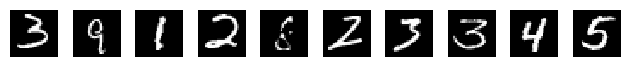

generated


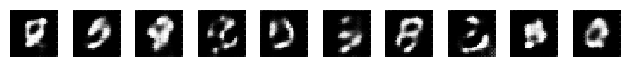

epoch 2005: [time: 271.5933322906494 ms]
epoch 2010: [time: 272.31907844543457 ms]
epoch 2015: [time: 274.3542194366455 ms]
epoch 2020: [time: 384.36293601989746 ms]
epoch 2025: [time: 283.261775970459 ms]
epoch 2030: [time: 270.25294303894043 ms]
epoch 2035: [time: 282.75609016418457 ms]
epoch 2040: [time: 283.8859558105469 ms]
epoch 2045: [time: 271.7623710632324 ms]
epoch 2050: [time: 286.2439155578613 ms]
epoch 2055: [time: 394.7563171386719 ms]
epoch 2060: [time: 269.14143562316895 ms]
epoch 2065: [time: 288.7101173400879 ms]
epoch 2070: [time: 287.92452812194824 ms]
epoch 2075: [time: 269.1967487335205 ms]
epoch 2080: [time: 280.20429611206055 ms]
epoch 2085: [time: 282.08136558532715 ms]
epoch 2090: [time: 313.7485980987549 ms]
epoch 2095: [time: 307.45792388916016 ms]
epoch 2100: [time: 282.5512886047363 ms]
[D loss: 2.10929673910141 | acc: 54.6875] [G loss: 2.0682647228240967]
real


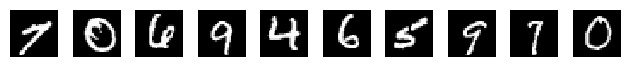

generated


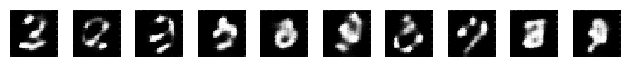

epoch 2105: [time: 284.8935127258301 ms]
epoch 2110: [time: 275.64358711242676 ms]
epoch 2115: [time: 291.5070056915283 ms]
epoch 2120: [time: 263.2129192352295 ms]
epoch 2125: [time: 268.8887119293213 ms]
epoch 2130: [time: 271.47793769836426 ms]
epoch 2135: [time: 271.4996337890625 ms]
epoch 2140: [time: 271.348237991333 ms]
epoch 2145: [time: 287.42051124572754 ms]
epoch 2150: [time: 270.86544036865234 ms]
epoch 2155: [time: 277.42505073547363 ms]
epoch 2160: [time: 284.52086448669434 ms]
epoch 2165: [time: 276.28612518310547 ms]
epoch 2170: [time: 279.8013687133789 ms]
epoch 2175: [time: 276.3710021972656 ms]
epoch 2180: [time: 266.049861907959 ms]
epoch 2185: [time: 267.1680450439453 ms]
epoch 2190: [time: 261.66820526123047 ms]
epoch 2195: [time: 274.7373580932617 ms]
epoch 2200: [time: 286.2513065338135 ms]
[D loss: 1.7897960245609283 | acc: 57.8125] [G loss: 2.393827438354492]
real


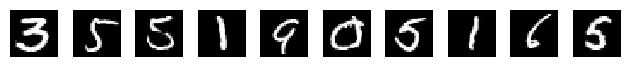

generated


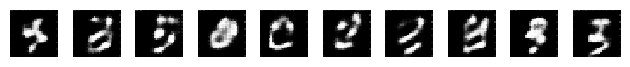

epoch 2205: [time: 294.9390411376953 ms]
epoch 2210: [time: 296.0476875305176 ms]
epoch 2215: [time: 273.12660217285156 ms]
epoch 2220: [time: 272.16076850891113 ms]
epoch 2225: [time: 281.2180519104004 ms]
epoch 2230: [time: 291.0950183868408 ms]
epoch 2235: [time: 269.38581466674805 ms]
epoch 2240: [time: 263.56053352355957 ms]
epoch 2245: [time: 264.3284797668457 ms]
epoch 2250: [time: 267.345666885376 ms]
epoch 2255: [time: 263.6139392852783 ms]
epoch 2260: [time: 286.84067726135254 ms]
epoch 2265: [time: 283.11896324157715 ms]
epoch 2270: [time: 302.57606506347656 ms]
epoch 2275: [time: 277.67372131347656 ms]
epoch 2280: [time: 263.2572650909424 ms]
epoch 2285: [time: 263.7171745300293 ms]
epoch 2290: [time: 270.66707611083984 ms]
epoch 2295: [time: 293.89214515686035 ms]
epoch 2300: [time: 293.6372756958008 ms]
[D loss: 1.8902567625045776 | acc: 57.03125] [G loss: 2.2267894744873047]
real


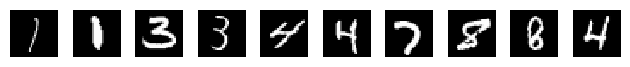

generated


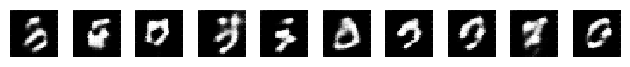

epoch 2305: [time: 286.00430488586426 ms]
epoch 2310: [time: 280.3795337677002 ms]
epoch 2315: [time: 280.2116870880127 ms]
epoch 2320: [time: 268.7852382659912 ms]
epoch 2325: [time: 384.5698833465576 ms]
epoch 2330: [time: 275.01797676086426 ms]
epoch 2335: [time: 261.00921630859375 ms]
epoch 2340: [time: 267.5495147705078 ms]
epoch 2345: [time: 273.33974838256836 ms]
epoch 2350: [time: 288.8190746307373 ms]
epoch 2355: [time: 266.002893447876 ms]
epoch 2360: [time: 410.3994369506836 ms]
epoch 2365: [time: 270.78962326049805 ms]
epoch 2370: [time: 279.01339530944824 ms]
epoch 2375: [time: 271.7573642730713 ms]
epoch 2380: [time: 272.810697555542 ms]
epoch 2385: [time: 282.5496196746826 ms]
epoch 2390: [time: 267.2736644744873 ms]
epoch 2395: [time: 395.85375785827637 ms]
epoch 2400: [time: 273.9396095275879 ms]
[D loss: 1.6976590156555176 | acc: 60.15625] [G loss: 2.6186704635620117]
real


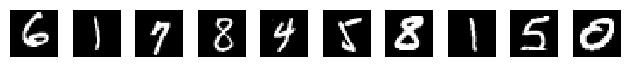

generated


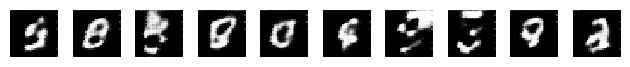

epoch 2405: [time: 274.85108375549316 ms]
epoch 2410: [time: 275.99263191223145 ms]
epoch 2415: [time: 282.672643661499 ms]
epoch 2420: [time: 276.8549919128418 ms]
epoch 2425: [time: 272.22490310668945 ms]
epoch 2430: [time: 444.42272186279297 ms]
epoch 2435: [time: 306.4734935760498 ms]
epoch 2440: [time: 276.2799263000488 ms]
epoch 2445: [time: 267.6873207092285 ms]
epoch 2450: [time: 275.7751941680908 ms]
epoch 2455: [time: 278.60069274902344 ms]
epoch 2460: [time: 273.43297004699707 ms]
epoch 2465: [time: 390.8693790435791 ms]
epoch 2470: [time: 293.46513748168945 ms]
epoch 2475: [time: 318.23110580444336 ms]
epoch 2480: [time: 272.991418838501 ms]
epoch 2485: [time: 266.92891120910645 ms]
epoch 2490: [time: 284.8999500274658 ms]
epoch 2495: [time: 286.33904457092285 ms]
epoch 2500: [time: 372.3869323730469 ms]
[D loss: 1.8853313103318214 | acc: 60.9375] [G loss: 3.050042152404785]
real


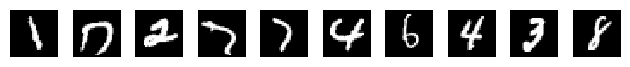

generated


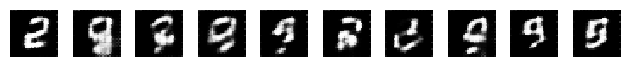

epoch 2505: [time: 274.28269386291504 ms]
epoch 2510: [time: 285.43996810913086 ms]
epoch 2515: [time: 268.9707279205322 ms]
epoch 2520: [time: 279.13856506347656 ms]
epoch 2525: [time: 276.02291107177734 ms]
epoch 2530: [time: 262.18152046203613 ms]
epoch 2535: [time: 394.4814205169678 ms]
epoch 2540: [time: 281.1236381530762 ms]
epoch 2545: [time: 273.5416889190674 ms]
epoch 2550: [time: 269.1490650177002 ms]
epoch 2555: [time: 271.01969718933105 ms]
epoch 2560: [time: 277.7712345123291 ms]
epoch 2565: [time: 252.17914581298828 ms]
epoch 2570: [time: 377.98094749450684 ms]
epoch 2575: [time: 287.01114654541016 ms]
epoch 2580: [time: 275.4662036895752 ms]
epoch 2585: [time: 295.4254150390625 ms]
epoch 2590: [time: 262.12024688720703 ms]
epoch 2595: [time: 289.56127166748047 ms]
epoch 2600: [time: 276.46899223327637 ms]
[D loss: 2.021214634180069 | acc: 59.375] [G loss: 3.0864977836608887]
real


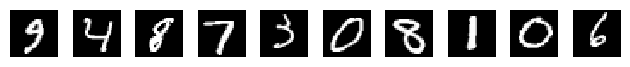

generated


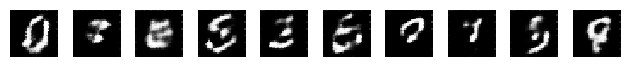

epoch 2605: [time: 273.2975482940674 ms]
epoch 2610: [time: 276.65257453918457 ms]
epoch 2615: [time: 272.8538513183594 ms]
epoch 2620: [time: 270.6799507141113 ms]
epoch 2625: [time: 277.5766849517822 ms]
epoch 2630: [time: 283.45727920532227 ms]
epoch 2635: [time: 287.3387336730957 ms]
epoch 2640: [time: 278.902530670166 ms]
epoch 2645: [time: 285.42065620422363 ms]
epoch 2650: [time: 272.3052501678467 ms]
epoch 2655: [time: 261.63649559020996 ms]
epoch 2660: [time: 269.84620094299316 ms]
epoch 2665: [time: 266.5855884552002 ms]
epoch 2670: [time: 276.4441967010498 ms]
epoch 2675: [time: 302.19149589538574 ms]
epoch 2680: [time: 315.4294490814209 ms]
epoch 2685: [time: 265.6846046447754 ms]
epoch 2690: [time: 281.2459468841553 ms]
epoch 2695: [time: 269.03390884399414 ms]
epoch 2700: [time: 269.81329917907715 ms]
[D loss: 1.8150657415390015 | acc: 55.46875] [G loss: 2.7747788429260254]
real


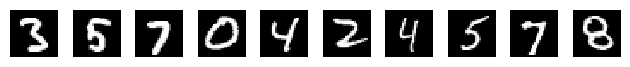

generated


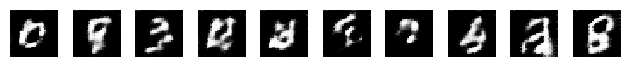

epoch 2705: [time: 284.52444076538086 ms]
epoch 2710: [time: 267.0276165008545 ms]
epoch 2715: [time: 257.83538818359375 ms]
epoch 2720: [time: 259.6733570098877 ms]
epoch 2725: [time: 267.73810386657715 ms]
epoch 2730: [time: 250.61821937561035 ms]
epoch 2735: [time: 267.2619819641113 ms]
epoch 2740: [time: 288.59519958496094 ms]
epoch 2745: [time: 280.58362007141113 ms]
epoch 2750: [time: 258.7916851043701 ms]
epoch 2755: [time: 261.35826110839844 ms]
epoch 2760: [time: 265.0570869445801 ms]
epoch 2765: [time: 276.22222900390625 ms]
epoch 2770: [time: 271.9743251800537 ms]
epoch 2775: [time: 284.0447425842285 ms]
epoch 2780: [time: 272.46880531311035 ms]
epoch 2785: [time: 285.60757637023926 ms]
epoch 2790: [time: 269.9005603790283 ms]
epoch 2795: [time: 271.651029586792 ms]
epoch 2800: [time: 289.49451446533203 ms]
[D loss: 1.947655126452446 | acc: 57.8125] [G loss: 2.8171262741088867]
real


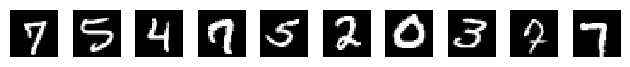

generated


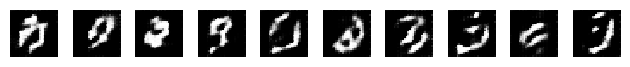

epoch 2805: [time: 395.79272270202637 ms]
epoch 2810: [time: 271.93641662597656 ms]
epoch 2815: [time: 273.5121250152588 ms]
epoch 2820: [time: 268.2318687438965 ms]
epoch 2825: [time: 275.10952949523926 ms]
epoch 2830: [time: 317.4328804016113 ms]
epoch 2835: [time: 295.84240913391113 ms]
epoch 2840: [time: 411.57007217407227 ms]
epoch 2845: [time: 274.3809223175049 ms]
epoch 2850: [time: 267.7619457244873 ms]
epoch 2855: [time: 264.38450813293457 ms]
epoch 2860: [time: 278.3498764038086 ms]
epoch 2865: [time: 261.885404586792 ms]
epoch 2870: [time: 296.62513732910156 ms]
epoch 2875: [time: 386.57593727111816 ms]
epoch 2880: [time: 262.0959281921387 ms]
epoch 2885: [time: 284.33871269226074 ms]
epoch 2890: [time: 276.0586738586426 ms]
epoch 2895: [time: 278.8968086242676 ms]
epoch 2900: [time: 273.207426071167 ms]
[D loss: 2.2835372984409332 | acc: 53.90625] [G loss: 2.843604564666748]
real


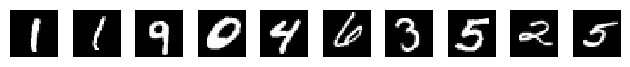

generated


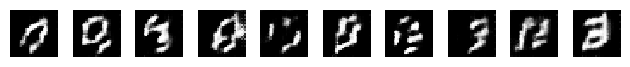

epoch 2905: [time: 271.01993560791016 ms]
epoch 2910: [time: 369.55785751342773 ms]
epoch 2915: [time: 285.41111946105957 ms]
epoch 2920: [time: 260.29229164123535 ms]
epoch 2925: [time: 266.11804962158203 ms]
epoch 2930: [time: 282.14526176452637 ms]
epoch 2935: [time: 273.81277084350586 ms]
epoch 2940: [time: 268.0926322937012 ms]
epoch 2945: [time: 381.8066120147705 ms]
epoch 2950: [time: 273.6928462982178 ms]
epoch 2955: [time: 279.5569896697998 ms]
epoch 2960: [time: 279.43968772888184 ms]
epoch 2965: [time: 284.46316719055176 ms]
epoch 2970: [time: 264.4326686859131 ms]
epoch 2975: [time: 271.62671089172363 ms]
epoch 2980: [time: 256.21914863586426 ms]
epoch 2985: [time: 279.4346809387207 ms]
epoch 2990: [time: 270.36142349243164 ms]
epoch 2995: [time: 283.3433151245117 ms]
epoch 3000: [time: 257.6179504394531 ms]
[D loss: 2.5159837901592255 | acc: 53.90625] [G loss: 2.7559194564819336]
real


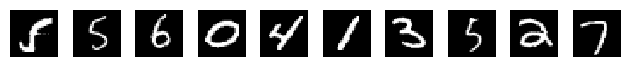

generated


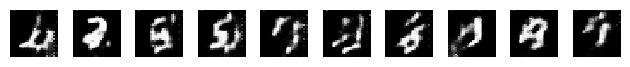

epoch 3005: [time: 268.83649826049805 ms]
epoch 3010: [time: 273.730993270874 ms]
epoch 3015: [time: 276.70788764953613 ms]
epoch 3020: [time: 270.82371711730957 ms]
epoch 3025: [time: 275.7580280303955 ms]
epoch 3030: [time: 260.941743850708 ms]
epoch 3035: [time: 267.35544204711914 ms]
epoch 3040: [time: 289.351224899292 ms]
epoch 3045: [time: 264.51635360717773 ms]
epoch 3050: [time: 282.0925712585449 ms]
epoch 3055: [time: 268.79191398620605 ms]
epoch 3060: [time: 278.23567390441895 ms]
epoch 3065: [time: 275.12383460998535 ms]
epoch 3070: [time: 268.68271827697754 ms]
epoch 3075: [time: 282.34076499938965 ms]
epoch 3080: [time: 295.3979969024658 ms]
epoch 3085: [time: 280.5640697479248 ms]
epoch 3090: [time: 276.68213844299316 ms]
epoch 3095: [time: 279.10757064819336 ms]
epoch 3100: [time: 287.00828552246094 ms]
[D loss: 1.7041226029396057 | acc: 63.28125] [G loss: 2.328273296356201]
real


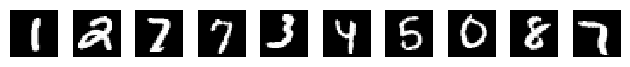

generated


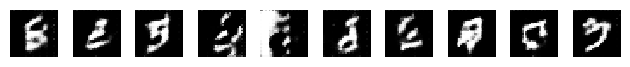

epoch 3105: [time: 282.825231552124 ms]
epoch 3110: [time: 287.80102729797363 ms]
epoch 3115: [time: 295.54152488708496 ms]
epoch 3120: [time: 283.85138511657715 ms]
epoch 3125: [time: 281.33368492126465 ms]
epoch 3130: [time: 273.5440731048584 ms]
epoch 3135: [time: 283.1103801727295 ms]
epoch 3140: [time: 290.9998893737793 ms]
epoch 3145: [time: 306.25176429748535 ms]
epoch 3150: [time: 401.2885093688965 ms]
epoch 3155: [time: 288.11192512512207 ms]
epoch 3160: [time: 285.74419021606445 ms]
epoch 3165: [time: 280.7128429412842 ms]
epoch 3170: [time: 300.5945682525635 ms]
epoch 3175: [time: 267.0440673828125 ms]
epoch 3180: [time: 264.8906707763672 ms]
epoch 3185: [time: 388.4258270263672 ms]
epoch 3190: [time: 276.4585018157959 ms]
epoch 3195: [time: 291.95284843444824 ms]
epoch 3200: [time: 277.41527557373047 ms]
[D loss: 1.9766433387994766 | acc: 60.15625] [G loss: 2.684513807296753]
real


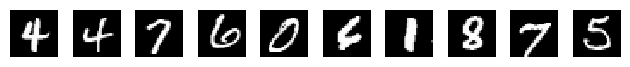

generated


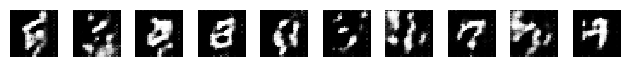

epoch 3205: [time: 293.72501373291016 ms]
epoch 3210: [time: 287.60504722595215 ms]
epoch 3215: [time: 279.5219421386719 ms]
epoch 3220: [time: 396.0540294647217 ms]
epoch 3225: [time: 290.04740715026855 ms]
epoch 3230: [time: 275.8219242095947 ms]
epoch 3235: [time: 296.58961296081543 ms]
epoch 3240: [time: 274.0809917449951 ms]
epoch 3245: [time: 267.5821781158447 ms]
epoch 3250: [time: 271.0146903991699 ms]
epoch 3255: [time: 398.4513282775879 ms]
epoch 3260: [time: 292.1144962310791 ms]
epoch 3265: [time: 260.85448265075684 ms]
epoch 3270: [time: 276.9970893859863 ms]
epoch 3275: [time: 281.5358638763428 ms]
epoch 3280: [time: 278.97167205810547 ms]
epoch 3285: [time: 269.80018615722656 ms]
epoch 3290: [time: 395.9660530090332 ms]
epoch 3295: [time: 255.95784187316895 ms]
epoch 3300: [time: 261.8060111999512 ms]
[D loss: 2.0149474442005157 | acc: 57.03125] [G loss: 1.9797585010528564]
real


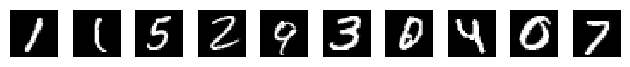

generated


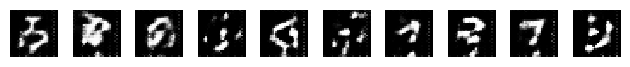

epoch 3305: [time: 286.940336227417 ms]
epoch 3310: [time: 266.8924331665039 ms]
epoch 3315: [time: 277.7848243713379 ms]
epoch 3320: [time: 274.51229095458984 ms]
epoch 3325: [time: 284.21831130981445 ms]
epoch 3330: [time: 289.4318103790283 ms]
epoch 3335: [time: 276.45421028137207 ms]
epoch 3340: [time: 283.39195251464844 ms]
epoch 3345: [time: 257.96008110046387 ms]
epoch 3350: [time: 273.5574245452881 ms]
epoch 3355: [time: 257.27152824401855 ms]
epoch 3360: [time: 300.0950813293457 ms]
epoch 3365: [time: 268.27025413513184 ms]
epoch 3370: [time: 275.1047611236572 ms]
epoch 3375: [time: 272.432804107666 ms]
epoch 3380: [time: 271.94905281066895 ms]
epoch 3385: [time: 263.4460926055908 ms]
epoch 3390: [time: 271.0137367248535 ms]
epoch 3395: [time: 294.9023246765137 ms]
epoch 3400: [time: 263.02051544189453 ms]
[D loss: 2.317014366388321 | acc: 55.46875] [G loss: 3.21766996383667]
real


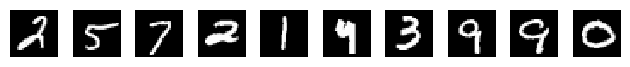

generated


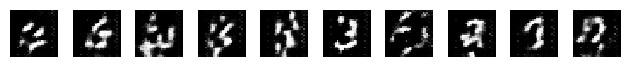

epoch 3405: [time: 262.9232406616211 ms]
epoch 3410: [time: 291.3811206817627 ms]
epoch 3415: [time: 280.58433532714844 ms]
epoch 3420: [time: 261.4140510559082 ms]
epoch 3425: [time: 297.8479862213135 ms]
epoch 3430: [time: 274.9512195587158 ms]
epoch 3435: [time: 308.19177627563477 ms]
epoch 3440: [time: 263.76914978027344 ms]
epoch 3445: [time: 289.5016670227051 ms]
epoch 3450: [time: 263.3178234100342 ms]
epoch 3455: [time: 279.2994976043701 ms]
epoch 3460: [time: 284.6839427947998 ms]
epoch 3465: [time: 279.8116207122803 ms]
epoch 3470: [time: 289.6394729614258 ms]
epoch 3475: [time: 267.9767608642578 ms]
epoch 3480: [time: 268.5685157775879 ms]
epoch 3485: [time: 272.7470397949219 ms]
epoch 3490: [time: 287.1356010437012 ms]
epoch 3495: [time: 372.9109764099121 ms]
epoch 3500: [time: 281.22782707214355 ms]
[D loss: 2.908477008342743 | acc: 48.4375] [G loss: 2.8976054191589355]
real


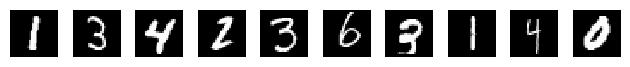

generated


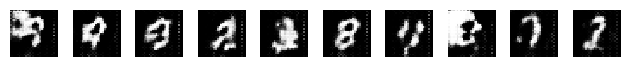

epoch 3505: [time: 260.8926296234131 ms]
epoch 3510: [time: 265.44761657714844 ms]
epoch 3515: [time: 291.7656898498535 ms]
epoch 3520: [time: 275.9819030761719 ms]
epoch 3525: [time: 258.50939750671387 ms]
epoch 3530: [time: 288.2516384124756 ms]
epoch 3535: [time: 284.23523902893066 ms]
epoch 3540: [time: 288.2871627807617 ms]
epoch 3545: [time: 269.18959617614746 ms]
epoch 3550: [time: 270.4782485961914 ms]
epoch 3555: [time: 265.1236057281494 ms]
epoch 3560: [time: 278.3820629119873 ms]
epoch 3565: [time: 276.477575302124 ms]
epoch 3570: [time: 268.47290992736816 ms]
epoch 3575: [time: 292.93131828308105 ms]
epoch 3580: [time: 269.70958709716797 ms]
epoch 3585: [time: 283.1907272338867 ms]
epoch 3590: [time: 282.6352119445801 ms]
epoch 3595: [time: 404.47402000427246 ms]
epoch 3600: [time: 276.03816986083984 ms]
[D loss: 2.9101962447166443 | acc: 57.8125] [G loss: 2.7251434326171875]
real


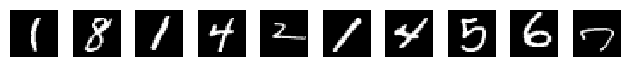

generated


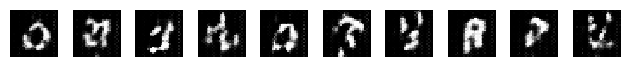

epoch 3605: [time: 299.47400093078613 ms]
epoch 3610: [time: 306.47897720336914 ms]
epoch 3615: [time: 280.7939052581787 ms]
epoch 3620: [time: 282.67836570739746 ms]
epoch 3625: [time: 279.9699306488037 ms]
epoch 3630: [time: 428.9882183074951 ms]
epoch 3635: [time: 274.9369144439697 ms]
epoch 3640: [time: 273.2224464416504 ms]
epoch 3645: [time: 292.42467880249023 ms]
epoch 3650: [time: 279.62207794189453 ms]
epoch 3655: [time: 267.0159339904785 ms]
epoch 3660: [time: 274.8899459838867 ms]
epoch 3665: [time: 372.33448028564453 ms]
epoch 3670: [time: 284.7461700439453 ms]
epoch 3675: [time: 270.6925868988037 ms]
epoch 3680: [time: 280.3230285644531 ms]
epoch 3685: [time: 272.5377082824707 ms]
epoch 3690: [time: 269.96374130249023 ms]
epoch 3695: [time: 282.6881408691406 ms]
epoch 3700: [time: 376.2795925140381 ms]
[D loss: 3.3415642380714417 | acc: 58.59375] [G loss: 2.882338523864746]
real


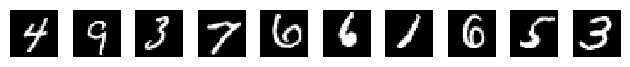

generated


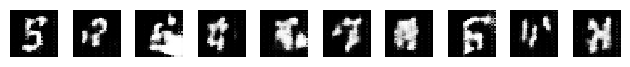

epoch 3705: [time: 267.2395706176758 ms]
epoch 3710: [time: 265.3226852416992 ms]
epoch 3715: [time: 275.3570079803467 ms]
epoch 3720: [time: 264.72949981689453 ms]
epoch 3725: [time: 289.31140899658203 ms]
epoch 3730: [time: 284.06333923339844 ms]
epoch 3735: [time: 274.1408348083496 ms]
epoch 3740: [time: 287.4011993408203 ms]
epoch 3745: [time: 280.8797359466553 ms]
epoch 3750: [time: 269.5648670196533 ms]
epoch 3755: [time: 255.45239448547363 ms]
epoch 3760: [time: 272.6864814758301 ms]
epoch 3765: [time: 260.32090187072754 ms]
epoch 3770: [time: 393.59211921691895 ms]
epoch 3775: [time: 273.6542224884033 ms]
epoch 3780: [time: 260.9543800354004 ms]
epoch 3785: [time: 285.6025695800781 ms]
epoch 3790: [time: 278.8233757019043 ms]
epoch 3795: [time: 284.6062183380127 ms]
epoch 3800: [time: 281.9705009460449 ms]
[D loss: 3.0616174936294556 | acc: 62.5] [G loss: 4.953747749328613]
real


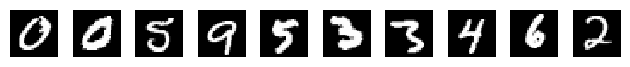

generated


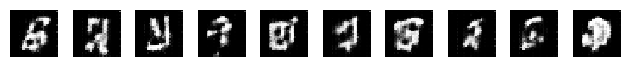

epoch 3805: [time: 289.8223400115967 ms]
epoch 3810: [time: 264.8942470550537 ms]
epoch 3815: [time: 272.3386287689209 ms]
epoch 3820: [time: 283.19811820983887 ms]
epoch 3825: [time: 278.062105178833 ms]
epoch 3830: [time: 272.2594738006592 ms]
epoch 3835: [time: 327.93569564819336 ms]
epoch 3840: [time: 285.7327461242676 ms]
epoch 3845: [time: 273.8761901855469 ms]
epoch 3850: [time: 284.23523902893066 ms]
epoch 3855: [time: 291.34297370910645 ms]
epoch 3860: [time: 269.12522315979004 ms]
epoch 3865: [time: 260.53428649902344 ms]
epoch 3870: [time: 390.0783061981201 ms]
epoch 3875: [time: 266.3459777832031 ms]
epoch 3880: [time: 282.224178314209 ms]
epoch 3885: [time: 285.2637767791748 ms]
epoch 3890: [time: 274.34802055358887 ms]
epoch 3895: [time: 288.65575790405273 ms]
epoch 3900: [time: 281.73041343688965 ms]
[D loss: 3.9946961402893066 | acc: 58.59375] [G loss: 3.1091361045837402]
real


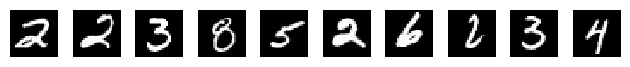

generated


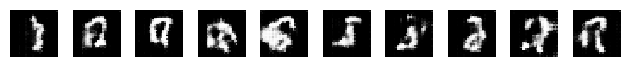

epoch 3905: [time: 274.27077293395996 ms]
epoch 3910: [time: 273.53811264038086 ms]
epoch 3915: [time: 269.5963382720947 ms]
epoch 3920: [time: 258.20088386535645 ms]
epoch 3925: [time: 265.67625999450684 ms]
epoch 3930: [time: 263.64684104919434 ms]
epoch 3935: [time: 284.8973274230957 ms]
epoch 3940: [time: 273.99635314941406 ms]
epoch 3945: [time: 266.74556732177734 ms]
epoch 3950: [time: 269.7625160217285 ms]
epoch 3955: [time: 254.32157516479492 ms]
epoch 3960: [time: 282.93776512145996 ms]
epoch 3965: [time: 266.6938304901123 ms]
epoch 3970: [time: 261.6851329803467 ms]
epoch 3975: [time: 292.31786727905273 ms]
epoch 3980: [time: 279.43944931030273 ms]
epoch 3985: [time: 267.8825855255127 ms]
epoch 3990: [time: 266.7512893676758 ms]
epoch 3995: [time: 276.84736251831055 ms]
epoch 4000: [time: 260.66017150878906 ms]
[D loss: 5.276739031076431 | acc: 55.46875] [G loss: 4.298819541931152]
real


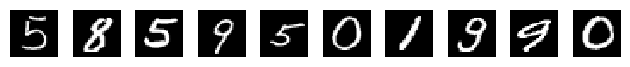

generated


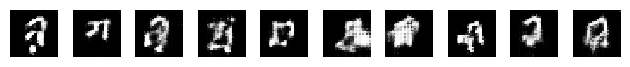

epoch 4005: [time: 261.0971927642822 ms]
epoch 4010: [time: 266.47067070007324 ms]
epoch 4015: [time: 286.6513729095459 ms]
epoch 4020: [time: 268.19872856140137 ms]
epoch 4025: [time: 269.6526050567627 ms]
epoch 4030: [time: 294.77500915527344 ms]
epoch 4035: [time: 277.0271301269531 ms]
epoch 4040: [time: 283.92529487609863 ms]
epoch 4045: [time: 296.3407039642334 ms]
epoch 4050: [time: 276.1509418487549 ms]
epoch 4055: [time: 281.9077968597412 ms]
epoch 4060: [time: 288.9752388000488 ms]
epoch 4065: [time: 271.2376117706299 ms]
epoch 4070: [time: 279.27207946777344 ms]
epoch 4075: [time: 268.0673599243164 ms]
epoch 4080: [time: 281.91232681274414 ms]
epoch 4085: [time: 276.7937183380127 ms]
epoch 4090: [time: 275.35033226013184 ms]
epoch 4095: [time: 286.7434024810791 ms]
epoch 4100: [time: 276.3817310333252 ms]
[D loss: 5.17146572470665 | acc: 55.46875] [G loss: 4.367541313171387]
real


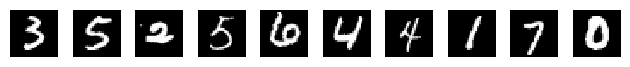

generated


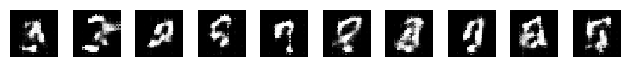

epoch 4105: [time: 286.2060070037842 ms]
epoch 4110: [time: 307.0039749145508 ms]
epoch 4115: [time: 289.63279724121094 ms]
epoch 4120: [time: 286.6942882537842 ms]
epoch 4125: [time: 267.24720001220703 ms]
epoch 4130: [time: 274.1708755493164 ms]
epoch 4135: [time: 285.31789779663086 ms]
epoch 4140: [time: 258.15868377685547 ms]
epoch 4145: [time: 400.2227783203125 ms]
epoch 4150: [time: 300.6911277770996 ms]
epoch 4155: [time: 279.1438102722168 ms]
epoch 4160: [time: 282.25088119506836 ms]
epoch 4165: [time: 268.71442794799805 ms]
epoch 4170: [time: 300.5869388580322 ms]
epoch 4175: [time: 282.79948234558105 ms]
epoch 4180: [time: 387.26234436035156 ms]
epoch 4185: [time: 290.64226150512695 ms]
epoch 4190: [time: 286.59820556640625 ms]
epoch 4195: [time: 293.37286949157715 ms]
epoch 4200: [time: 260.5149745941162 ms]
[D loss: 6.560602307319641 | acc: 52.34375] [G loss: 4.603092193603516]
real


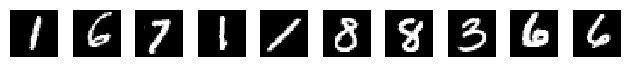

generated


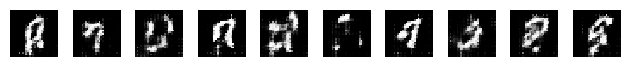

epoch 4205: [time: 281.1574935913086 ms]
epoch 4210: [time: 272.4955081939697 ms]
epoch 4215: [time: 273.9744186401367 ms]
epoch 4220: [time: 268.4521675109863 ms]
epoch 4225: [time: 281.85319900512695 ms]
epoch 4230: [time: 265.28429985046387 ms]
epoch 4235: [time: 260.6198787689209 ms]
epoch 4240: [time: 261.1076831817627 ms]
epoch 4245: [time: 267.5204277038574 ms]
epoch 4250: [time: 272.5052833557129 ms]
epoch 4255: [time: 278.7649631500244 ms]
epoch 4260: [time: 274.2888927459717 ms]
epoch 4265: [time: 284.285306930542 ms]
epoch 4270: [time: 274.3563652038574 ms]
epoch 4275: [time: 269.6974277496338 ms]
epoch 4280: [time: 261.69705390930176 ms]
epoch 4285: [time: 316.40028953552246 ms]
epoch 4290: [time: 271.7249393463135 ms]
epoch 4295: [time: 293.1487560272217 ms]
epoch 4300: [time: 269.5598602294922 ms]
[D loss: 6.307101666927338 | acc: 53.125] [G loss: 4.103298664093018]
real


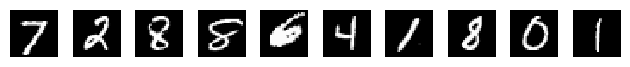

generated


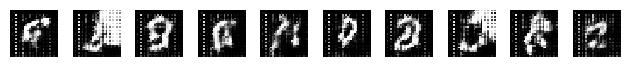

epoch 4305: [time: 294.999361038208 ms]
epoch 4310: [time: 284.40403938293457 ms]
epoch 4315: [time: 303.60960960388184 ms]
epoch 4320: [time: 287.85181045532227 ms]
epoch 4325: [time: 297.0752716064453 ms]
epoch 4330: [time: 270.8902359008789 ms]
epoch 4335: [time: 292.16527938842773 ms]
epoch 4340: [time: 256.24561309814453 ms]
epoch 4345: [time: 286.0984802246094 ms]
epoch 4350: [time: 288.96307945251465 ms]
epoch 4355: [time: 349.0471839904785 ms]
epoch 4360: [time: 283.16783905029297 ms]
epoch 4365: [time: 340.6798839569092 ms]
epoch 4370: [time: 286.38362884521484 ms]
epoch 4375: [time: 275.249719619751 ms]
epoch 4380: [time: 264.9531364440918 ms]
epoch 4385: [time: 284.7745418548584 ms]
epoch 4390: [time: 278.9273262023926 ms]
epoch 4395: [time: 272.67980575561523 ms]
epoch 4400: [time: 268.20945739746094 ms]
[D loss: 8.226798295974731 | acc: 46.875] [G loss: 3.667691230773926]
real


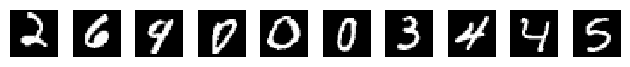

generated


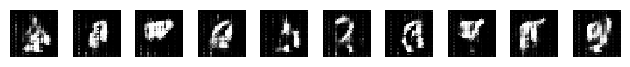

epoch 4405: [time: 277.42624282836914 ms]
epoch 4410: [time: 267.5900459289551 ms]
epoch 4415: [time: 268.5201168060303 ms]
epoch 4420: [time: 283.07509422302246 ms]
epoch 4425: [time: 279.80828285217285 ms]
epoch 4430: [time: 305.50670623779297 ms]
epoch 4435: [time: 281.8639278411865 ms]
epoch 4440: [time: 266.4458751678467 ms]
epoch 4445: [time: 278.60045433044434 ms]
epoch 4450: [time: 270.2302932739258 ms]
epoch 4455: [time: 280.2290916442871 ms]
epoch 4460: [time: 285.48216819763184 ms]
epoch 4465: [time: 283.2636833190918 ms]
epoch 4470: [time: 266.4000988006592 ms]
epoch 4475: [time: 283.04433822631836 ms]
epoch 4480: [time: 272.83763885498047 ms]
epoch 4485: [time: 270.4014778137207 ms]
epoch 4490: [time: 273.303747177124 ms]
epoch 4495: [time: 291.7819023132324 ms]
epoch 4500: [time: 275.50554275512695 ms]
[D loss: 5.69501057267189 | acc: 60.15625] [G loss: 4.401609420776367]
real


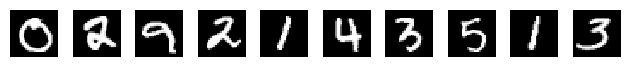

generated


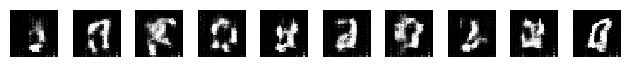

epoch 4505: [time: 285.43591499328613 ms]
epoch 4510: [time: 278.89299392700195 ms]
epoch 4515: [time: 268.1252956390381 ms]
epoch 4520: [time: 263.7622356414795 ms]
epoch 4525: [time: 293.40171813964844 ms]
epoch 4530: [time: 301.4514446258545 ms]
epoch 4535: [time: 281.63790702819824 ms]
epoch 4540: [time: 288.9401912689209 ms]
epoch 4545: [time: 278.6858081817627 ms]
epoch 4550: [time: 267.43102073669434 ms]
epoch 4555: [time: 263.36169242858887 ms]
epoch 4560: [time: 279.0188789367676 ms]
epoch 4565: [time: 298.0692386627197 ms]
epoch 4570: [time: 262.1347904205322 ms]
epoch 4575: [time: 269.81401443481445 ms]
epoch 4580: [time: 269.0589427947998 ms]
epoch 4585: [time: 268.2976722717285 ms]
epoch 4590: [time: 290.637731552124 ms]
epoch 4595: [time: 398.67520332336426 ms]
epoch 4600: [time: 272.7208137512207 ms]
[D loss: 7.9974483251571655 | acc: 53.125] [G loss: 6.039711952209473]
real


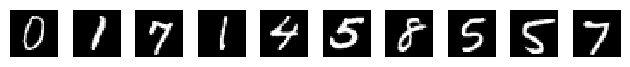

generated


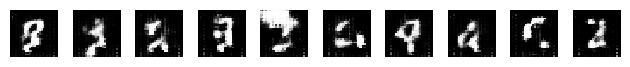

epoch 4605: [time: 278.7442207336426 ms]
epoch 4610: [time: 288.4101867675781 ms]
epoch 4615: [time: 275.14147758483887 ms]
epoch 4620: [time: 275.3438949584961 ms]
epoch 4625: [time: 311.7706775665283 ms]
epoch 4630: [time: 288.7763977050781 ms]
epoch 4635: [time: 297.0285415649414 ms]
epoch 4640: [time: 296.83756828308105 ms]
epoch 4645: [time: 276.76892280578613 ms]
epoch 4650: [time: 273.7693786621094 ms]
epoch 4655: [time: 278.7444591522217 ms]
epoch 4660: [time: 294.4612503051758 ms]
epoch 4665: [time: 279.9558639526367 ms]
epoch 4670: [time: 281.02564811706543 ms]
epoch 4675: [time: 271.61383628845215 ms]
epoch 4680: [time: 255.7206153869629 ms]
epoch 4685: [time: 280.09986877441406 ms]
epoch 4690: [time: 276.1225700378418 ms]
epoch 4695: [time: 383.6636543273926 ms]
epoch 4700: [time: 280.38954734802246 ms]
[D loss: 5.170572400093079 | acc: 60.15625] [G loss: 5.005030632019043]
real


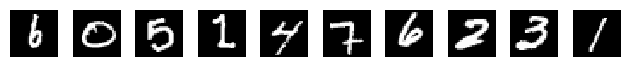

generated


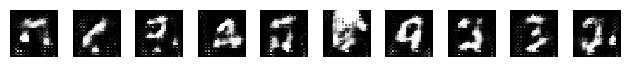

epoch 4705: [time: 282.30929374694824 ms]
epoch 4710: [time: 297.4722385406494 ms]
epoch 4715: [time: 267.58742332458496 ms]
epoch 4720: [time: 276.3948440551758 ms]
epoch 4725: [time: 273.8180160522461 ms]
epoch 4730: [time: 286.7558002471924 ms]
epoch 4735: [time: 271.0223197937012 ms]
epoch 4740: [time: 261.38854026794434 ms]
epoch 4745: [time: 282.00364112854004 ms]
epoch 4750: [time: 286.82732582092285 ms]
epoch 4755: [time: 271.7013359069824 ms]
epoch 4760: [time: 257.3387622833252 ms]
epoch 4765: [time: 273.70214462280273 ms]
epoch 4770: [time: 266.9360637664795 ms]
epoch 4775: [time: 263.4315490722656 ms]
epoch 4780: [time: 336.8089199066162 ms]
epoch 4785: [time: 267.82703399658203 ms]
epoch 4790: [time: 266.30139350891113 ms]
epoch 4795: [time: 278.61523628234863 ms]
epoch 4800: [time: 286.00001335144043 ms]
[D loss: 9.394177854061127 | acc: 53.125] [G loss: 4.899312973022461]
real


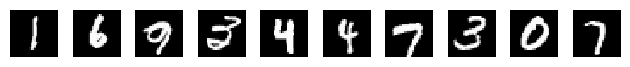

generated


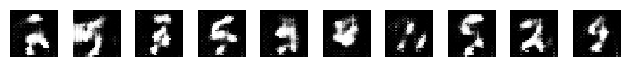

epoch 4805: [time: 271.03281021118164 ms]
epoch 4810: [time: 265.5494213104248 ms]
epoch 4815: [time: 262.0980739593506 ms]
epoch 4820: [time: 258.60595703125 ms]
epoch 4825: [time: 290.85540771484375 ms]
epoch 4830: [time: 255.17010688781738 ms]
epoch 4835: [time: 276.8054008483887 ms]
epoch 4840: [time: 293.0335998535156 ms]
epoch 4845: [time: 285.43853759765625 ms]
epoch 4850: [time: 266.8771743774414 ms]
epoch 4855: [time: 270.4479694366455 ms]
epoch 4860: [time: 274.3420600891113 ms]
epoch 4865: [time: 272.7482318878174 ms]
epoch 4870: [time: 274.0447521209717 ms]
epoch 4875: [time: 276.9918441772461 ms]
epoch 4880: [time: 271.04806900024414 ms]
epoch 4885: [time: 302.8280735015869 ms]
epoch 4890: [time: 271.23069763183594 ms]
epoch 4895: [time: 295.8660125732422 ms]
epoch 4900: [time: 288.98048400878906 ms]
[D loss: 9.24010345339775 | acc: 60.15625] [G loss: 7.137141227722168]
real


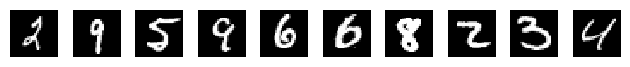

generated


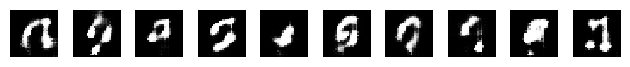

epoch 4905: [time: 289.51120376586914 ms]
epoch 4910: [time: 270.2145576477051 ms]
epoch 4915: [time: 265.1214599609375 ms]
epoch 4920: [time: 278.11145782470703 ms]
epoch 4925: [time: 271.5766429901123 ms]
epoch 4930: [time: 267.8804397583008 ms]
epoch 4935: [time: 298.4275817871094 ms]
epoch 4940: [time: 269.8700428009033 ms]
epoch 4945: [time: 264.2202377319336 ms]
epoch 4950: [time: 279.70075607299805 ms]
epoch 4955: [time: 268.21160316467285 ms]
epoch 4960: [time: 292.3316955566406 ms]
epoch 4965: [time: 269.52672004699707 ms]
epoch 4970: [time: 265.20776748657227 ms]
epoch 4975: [time: 267.9872512817383 ms]
epoch 4980: [time: 251.8768310546875 ms]
epoch 4985: [time: 276.2289047241211 ms]
epoch 4990: [time: 316.90287590026855 ms]
epoch 4995: [time: 298.1982231140137 ms]
epoch 5000: [time: 259.5360279083252 ms]
[D loss: 8.529741048812866 | acc: 60.15625] [G loss: 6.875847816467285]
real


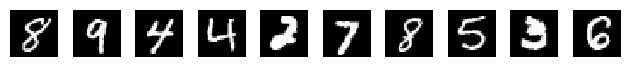

generated


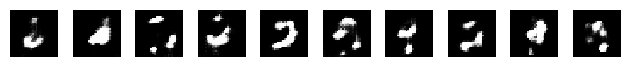

epoch 5005: [time: 274.49536323547363 ms]
epoch 5010: [time: 280.63058853149414 ms]
epoch 5015: [time: 259.890079498291 ms]
epoch 5020: [time: 261.1548900604248 ms]
epoch 5025: [time: 257.8110694885254 ms]
epoch 5030: [time: 268.36609840393066 ms]
epoch 5035: [time: 257.7202320098877 ms]
epoch 5040: [time: 281.6605567932129 ms]
epoch 5045: [time: 293.6129570007324 ms]
epoch 5050: [time: 297.0147132873535 ms]
epoch 5055: [time: 266.493558883667 ms]
epoch 5060: [time: 275.5126953125 ms]
epoch 5065: [time: 255.28693199157715 ms]
epoch 5070: [time: 249.47547912597656 ms]
epoch 5075: [time: 277.7223587036133 ms]
epoch 5080: [time: 275.0082015991211 ms]
epoch 5085: [time: 267.9867744445801 ms]
epoch 5090: [time: 265.66195487976074 ms]
epoch 5095: [time: 274.31392669677734 ms]
epoch 5100: [time: 257.82060623168945 ms]
[D loss: 11.045666217803955 | acc: 48.4375] [G loss: 8.073892593383789]
real


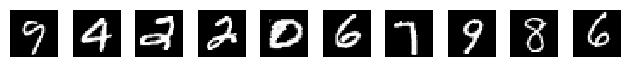

generated


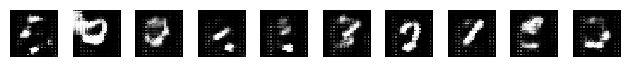

epoch 5105: [time: 272.216796875 ms]
epoch 5110: [time: 284.85727310180664 ms]
epoch 5115: [time: 253.16143035888672 ms]
epoch 5120: [time: 270.916223526001 ms]
epoch 5125: [time: 276.0915756225586 ms]
epoch 5130: [time: 296.2312698364258 ms]
epoch 5135: [time: 258.5282325744629 ms]
epoch 5140: [time: 283.5562229156494 ms]
epoch 5145: [time: 281.9688320159912 ms]
epoch 5150: [time: 292.6497459411621 ms]
epoch 5155: [time: 272.4432945251465 ms]
epoch 5160: [time: 275.09427070617676 ms]
epoch 5165: [time: 290.11988639831543 ms]
epoch 5170: [time: 281.62264823913574 ms]
epoch 5175: [time: 298.07257652282715 ms]
epoch 5180: [time: 280.90643882751465 ms]
epoch 5185: [time: 292.10853576660156 ms]
epoch 5190: [time: 280.0583839416504 ms]
epoch 5195: [time: 277.7407169342041 ms]
epoch 5200: [time: 296.83661460876465 ms]
[D loss: 8.458451747894287 | acc: 53.125] [G loss: 5.567686557769775]
real


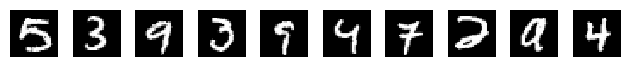

generated


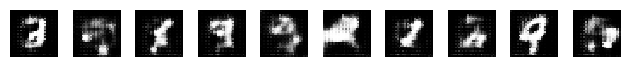

epoch 5205: [time: 272.4435329437256 ms]
epoch 5210: [time: 285.4154109954834 ms]
epoch 5215: [time: 287.9204750061035 ms]
epoch 5220: [time: 270.6034183502197 ms]
epoch 5225: [time: 269.395112991333 ms]
epoch 5230: [time: 270.4277038574219 ms]
epoch 5235: [time: 269.59824562072754 ms]
epoch 5240: [time: 277.87041664123535 ms]
epoch 5245: [time: 293.7932014465332 ms]
epoch 5250: [time: 285.01152992248535 ms]
epoch 5255: [time: 279.55031394958496 ms]
epoch 5260: [time: 304.34632301330566 ms]
epoch 5265: [time: 272.5536823272705 ms]
epoch 5270: [time: 275.94566345214844 ms]
epoch 5275: [time: 280.0304889678955 ms]
epoch 5280: [time: 270.9696292877197 ms]
epoch 5285: [time: 265.4097080230713 ms]
epoch 5290: [time: 265.9773826599121 ms]
epoch 5295: [time: 276.25346183776855 ms]
epoch 5300: [time: 275.04754066467285 ms]
[D loss: 10.868685483932495 | acc: 51.5625] [G loss: 5.663447380065918]
real


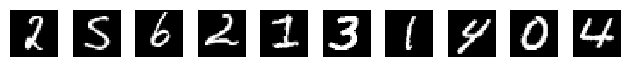

generated


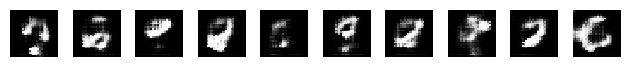

epoch 5305: [time: 281.5513610839844 ms]
epoch 5310: [time: 267.0321464538574 ms]
epoch 5315: [time: 283.7998867034912 ms]
epoch 5320: [time: 272.65143394470215 ms]
epoch 5325: [time: 273.99539947509766 ms]
epoch 5330: [time: 267.11535453796387 ms]
epoch 5335: [time: 277.3253917694092 ms]
epoch 5340: [time: 272.3715305328369 ms]
epoch 5345: [time: 271.9082832336426 ms]
epoch 5350: [time: 292.72985458374023 ms]
epoch 5355: [time: 265.38586616516113 ms]
epoch 5360: [time: 284.5630645751953 ms]
epoch 5365: [time: 273.29206466674805 ms]
epoch 5370: [time: 287.17541694641113 ms]
epoch 5375: [time: 286.37146949768066 ms]
epoch 5380: [time: 271.15821838378906 ms]
epoch 5385: [time: 619.657039642334 ms]
epoch 5390: [time: 273.5435962677002 ms]
epoch 5395: [time: 280.487060546875 ms]
epoch 5400: [time: 286.17119789123535 ms]
[D loss: 12.09374737739563 | acc: 48.4375] [G loss: 5.790811538696289]
real


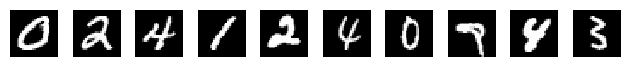

generated


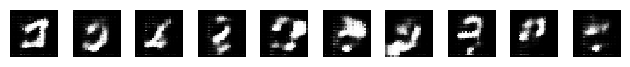

epoch 5405: [time: 289.13021087646484 ms]
epoch 5410: [time: 346.47631645202637 ms]
epoch 5415: [time: 293.7791347503662 ms]
epoch 5420: [time: 274.3401527404785 ms]
epoch 5425: [time: 285.8433723449707 ms]
epoch 5430: [time: 257.11917877197266 ms]
epoch 5435: [time: 271.803617477417 ms]
epoch 5440: [time: 270.3394889831543 ms]
epoch 5445: [time: 257.3060989379883 ms]
epoch 5450: [time: 282.3445796966553 ms]
epoch 5455: [time: 276.3841152191162 ms]
epoch 5460: [time: 269.2253589630127 ms]
epoch 5465: [time: 287.14513778686523 ms]
epoch 5470: [time: 297.5006103515625 ms]
epoch 5475: [time: 282.412052154541 ms]
epoch 5480: [time: 281.19611740112305 ms]
epoch 5485: [time: 291.93592071533203 ms]
epoch 5490: [time: 272.89533615112305 ms]
epoch 5495: [time: 280.2538871765137 ms]
epoch 5500: [time: 245.3765869140625 ms]
[D loss: 8.61474871635437 | acc: 54.6875] [G loss: 5.5523247718811035]
real


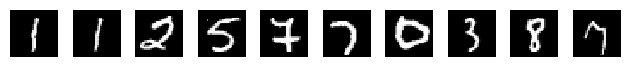

generated


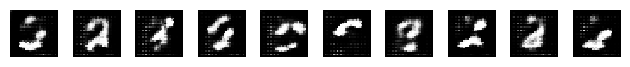

epoch 5505: [time: 277.4958610534668 ms]
epoch 5510: [time: 287.3857021331787 ms]
epoch 5515: [time: 285.9489917755127 ms]
epoch 5520: [time: 273.25916290283203 ms]
epoch 5525: [time: 279.6595096588135 ms]
epoch 5530: [time: 276.1969566345215 ms]
epoch 5535: [time: 270.86877822875977 ms]
epoch 5540: [time: 265.43378829956055 ms]
epoch 5545: [time: 295.23587226867676 ms]
epoch 5550: [time: 255.6934356689453 ms]
epoch 5555: [time: 264.9710178375244 ms]
epoch 5560: [time: 281.21304512023926 ms]
epoch 5565: [time: 283.8261127471924 ms]
epoch 5570: [time: 299.1063594818115 ms]
epoch 5575: [time: 259.56082344055176 ms]
epoch 5580: [time: 257.88307189941406 ms]
epoch 5585: [time: 275.4244804382324 ms]
epoch 5590: [time: 277.024507522583 ms]
epoch 5595: [time: 264.84203338623047 ms]
epoch 5600: [time: 260.52308082580566 ms]
[D loss: 9.216856181621552 | acc: 51.5625] [G loss: 4.222517967224121]
real


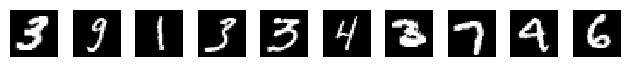

generated


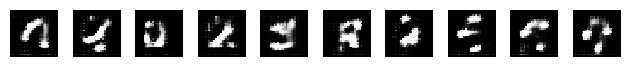

epoch 5605: [time: 273.266077041626 ms]
epoch 5610: [time: 277.1422863006592 ms]
epoch 5615: [time: 282.0296287536621 ms]
epoch 5620: [time: 285.7069969177246 ms]
epoch 5625: [time: 282.3638916015625 ms]
epoch 5630: [time: 286.2083911895752 ms]
epoch 5635: [time: 277.9965400695801 ms]
epoch 5640: [time: 287.006139755249 ms]
epoch 5645: [time: 263.9033794403076 ms]
epoch 5650: [time: 272.42302894592285 ms]
epoch 5655: [time: 266.82233810424805 ms]
epoch 5660: [time: 280.0562381744385 ms]
epoch 5665: [time: 267.4407958984375 ms]
epoch 5670: [time: 276.2637138366699 ms]
epoch 5675: [time: 273.3874320983887 ms]
epoch 5680: [time: 289.0908718109131 ms]
epoch 5685: [time: 276.3173580169678 ms]
epoch 5690: [time: 274.0213871002197 ms]
epoch 5695: [time: 278.58805656433105 ms]
epoch 5700: [time: 291.4152145385742 ms]
[D loss: 9.592691779136658 | acc: 55.46875] [G loss: 4.632343769073486]
real


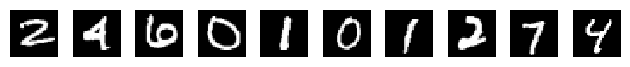

generated


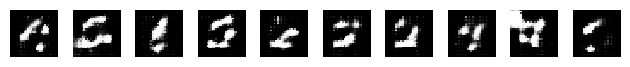

epoch 5705: [time: 256.9844722747803 ms]
epoch 5710: [time: 256.3209533691406 ms]
epoch 5715: [time: 284.2996120452881 ms]
epoch 5720: [time: 280.0722122192383 ms]
epoch 5725: [time: 288.7301445007324 ms]
epoch 5730: [time: 276.3395309448242 ms]
epoch 5735: [time: 280.79676628112793 ms]
epoch 5740: [time: 274.85156059265137 ms]
epoch 5745: [time: 255.50246238708496 ms]
epoch 5750: [time: 274.1885185241699 ms]
epoch 5755: [time: 267.0459747314453 ms]
epoch 5760: [time: 294.2168712615967 ms]
epoch 5765: [time: 271.2857723236084 ms]
epoch 5770: [time: 256.1359405517578 ms]
epoch 5775: [time: 254.11033630371094 ms]
epoch 5780: [time: 263.48066329956055 ms]
epoch 5785: [time: 272.8312015533447 ms]
epoch 5790: [time: 274.2478847503662 ms]
epoch 5795: [time: 284.99579429626465 ms]
epoch 5800: [time: 264.8894786834717 ms]
[D loss: 8.391473293304443 | acc: 54.6875] [G loss: 5.53776741027832]
real


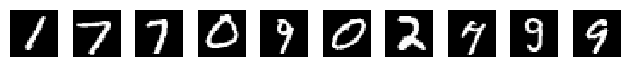

generated


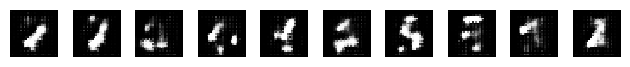

epoch 5805: [time: 273.8950252532959 ms]
epoch 5810: [time: 276.71217918395996 ms]
epoch 5815: [time: 260.2190971374512 ms]
epoch 5820: [time: 270.48754692077637 ms]
epoch 5825: [time: 267.1968936920166 ms]
epoch 5830: [time: 268.5093879699707 ms]
epoch 5835: [time: 281.2991142272949 ms]
epoch 5840: [time: 281.1751365661621 ms]
epoch 5845: [time: 269.6685791015625 ms]
epoch 5850: [time: 274.0762233734131 ms]
epoch 5855: [time: 263.9923095703125 ms]
epoch 5860: [time: 273.449182510376 ms]
epoch 5865: [time: 280.8232307434082 ms]
epoch 5870: [time: 279.1781425476074 ms]
epoch 5875: [time: 261.660099029541 ms]
epoch 5880: [time: 250.28514862060547 ms]
epoch 5885: [time: 252.87175178527832 ms]
epoch 5890: [time: 261.06977462768555 ms]
epoch 5895: [time: 265.9730911254883 ms]
epoch 5900: [time: 279.3281078338623 ms]
[D loss: 9.107995390892029 | acc: 50.78125] [G loss: 5.715009689331055]
real


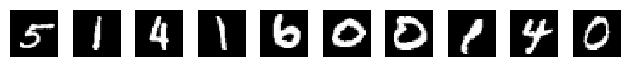

generated


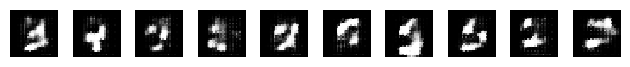

epoch 5905: [time: 269.5753574371338 ms]
epoch 5910: [time: 266.42632484436035 ms]
epoch 5915: [time: 276.57008171081543 ms]
epoch 5920: [time: 274.08337593078613 ms]
epoch 5925: [time: 279.329776763916 ms]
epoch 5930: [time: 277.6317596435547 ms]
epoch 5935: [time: 286.30828857421875 ms]
epoch 5940: [time: 300.47035217285156 ms]
epoch 5945: [time: 270.54500579833984 ms]
epoch 5950: [time: 285.2451801300049 ms]
epoch 5955: [time: 281.32152557373047 ms]
epoch 5960: [time: 294.5282459259033 ms]
epoch 5965: [time: 281.9836139678955 ms]
epoch 5970: [time: 289.4136905670166 ms]
epoch 5975: [time: 280.32922744750977 ms]
epoch 5980: [time: 266.42656326293945 ms]
epoch 5985: [time: 275.8440971374512 ms]
epoch 5990: [time: 278.195858001709 ms]
epoch 5995: [time: 282.9294204711914 ms]
epoch 6000: [time: 286.2067222595215 ms]
[D loss: 7.1292316019535065 | acc: 53.90625] [G loss: 6.131400108337402]
real


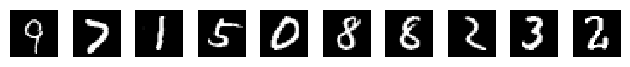

generated


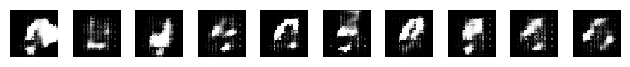

epoch 6005: [time: 284.70516204833984 ms]
epoch 6010: [time: 265.5644416809082 ms]
epoch 6015: [time: 273.6246585845947 ms]
epoch 6020: [time: 248.67868423461914 ms]
epoch 6025: [time: 245.6357479095459 ms]
epoch 6030: [time: 255.55109977722168 ms]
epoch 6035: [time: 270.8737850189209 ms]
epoch 6040: [time: 310.99605560302734 ms]
epoch 6045: [time: 264.8277282714844 ms]
epoch 6050: [time: 267.4534320831299 ms]
epoch 6055: [time: 258.0115795135498 ms]
epoch 6060: [time: 272.60565757751465 ms]
epoch 6065: [time: 281.20970726013184 ms]
epoch 6070: [time: 262.48669624328613 ms]
epoch 6075: [time: 256.328821182251 ms]
epoch 6080: [time: 256.94894790649414 ms]
epoch 6085: [time: 258.27813148498535 ms]
epoch 6090: [time: 268.77808570861816 ms]
epoch 6095: [time: 270.4501152038574 ms]
epoch 6100: [time: 268.33558082580566 ms]
[D loss: 8.683067083358765 | acc: 56.25] [G loss: 6.987667083740234]
real


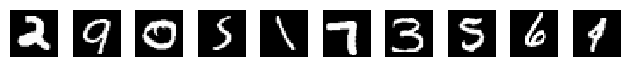

generated


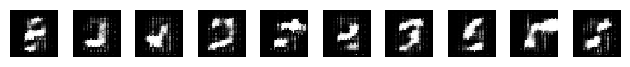

epoch 6105: [time: 266.5703296661377 ms]
epoch 6110: [time: 280.09486198425293 ms]
epoch 6115: [time: 252.8085708618164 ms]
epoch 6120: [time: 278.49650382995605 ms]
epoch 6125: [time: 265.0494575500488 ms]
epoch 6130: [time: 268.4497833251953 ms]
epoch 6135: [time: 273.8461494445801 ms]
epoch 6140: [time: 263.3492946624756 ms]
epoch 6145: [time: 269.45996284484863 ms]
epoch 6150: [time: 285.60733795166016 ms]
epoch 6155: [time: 293.81608963012695 ms]
epoch 6160: [time: 311.3734722137451 ms]
epoch 6165: [time: 297.49393463134766 ms]
epoch 6170: [time: 282.3789119720459 ms]
epoch 6175: [time: 279.60968017578125 ms]
epoch 6180: [time: 284.52539443969727 ms]
epoch 6185: [time: 266.90196990966797 ms]
epoch 6190: [time: 284.106969833374 ms]
epoch 6195: [time: 284.8684787750244 ms]
epoch 6200: [time: 292.88601875305176 ms]
[D loss: 9.055967152118683 | acc: 58.59375] [G loss: 7.574071884155273]
real


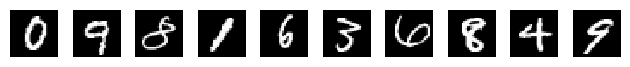

generated


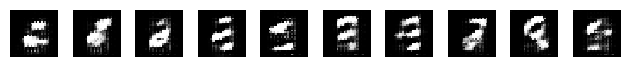

epoch 6205: [time: 292.7398681640625 ms]
epoch 6210: [time: 279.5381546020508 ms]
epoch 6215: [time: 305.93276023864746 ms]
epoch 6220: [time: 286.9091033935547 ms]
epoch 6225: [time: 275.61402320861816 ms]
epoch 6230: [time: 264.28985595703125 ms]
epoch 6235: [time: 297.13916778564453 ms]
epoch 6240: [time: 276.9782543182373 ms]
epoch 6245: [time: 291.20683670043945 ms]
epoch 6250: [time: 323.9707946777344 ms]
epoch 6255: [time: 340.8675193786621 ms]
epoch 6260: [time: 298.0773448944092 ms]
epoch 6265: [time: 278.8228988647461 ms]
epoch 6270: [time: 279.30665016174316 ms]
epoch 6275: [time: 276.9739627838135 ms]
epoch 6280: [time: 283.5245132446289 ms]
epoch 6285: [time: 279.8333168029785 ms]
epoch 6290: [time: 272.5510597229004 ms]
epoch 6295: [time: 285.5410575866699 ms]
epoch 6300: [time: 276.7975330352783 ms]
[D loss: 10.261996150016785 | acc: 62.5] [G loss: 8.59321403503418]
real


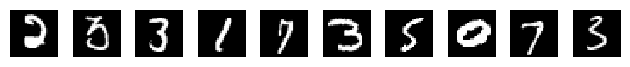

generated


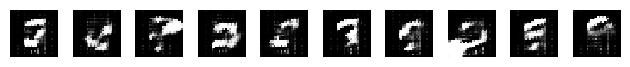

epoch 6305: [time: 278.2466411590576 ms]
epoch 6310: [time: 271.5005874633789 ms]
epoch 6315: [time: 285.52794456481934 ms]
epoch 6320: [time: 270.2829837799072 ms]
epoch 6325: [time: 280.0407409667969 ms]
epoch 6330: [time: 264.96434211730957 ms]
epoch 6335: [time: 276.32737159729004 ms]
epoch 6340: [time: 266.2768363952637 ms]
epoch 6345: [time: 271.76475524902344 ms]
epoch 6350: [time: 267.38834381103516 ms]
epoch 6355: [time: 262.4478340148926 ms]
epoch 6360: [time: 281.27360343933105 ms]
epoch 6365: [time: 261.9650363922119 ms]
epoch 6370: [time: 280.4555892944336 ms]
epoch 6375: [time: 274.88064765930176 ms]
epoch 6380: [time: 282.5348377227783 ms]
epoch 6385: [time: 268.18037033081055 ms]
epoch 6390: [time: 271.7454433441162 ms]
epoch 6395: [time: 288.210391998291 ms]
epoch 6400: [time: 258.2533359527588 ms]
[D loss: 13.014168620109558 | acc: 49.21875] [G loss: 9.376699447631836]
real


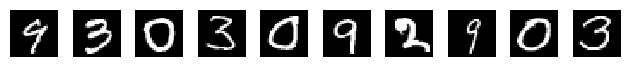

generated


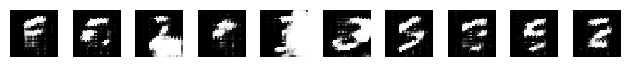

epoch 6405: [time: 283.4346294403076 ms]
epoch 6410: [time: 312.4403953552246 ms]
epoch 6415: [time: 309.62681770324707 ms]
epoch 6420: [time: 287.16325759887695 ms]
epoch 6425: [time: 304.3050765991211 ms]
epoch 6430: [time: 266.2789821624756 ms]
epoch 6435: [time: 263.75865936279297 ms]
epoch 6440: [time: 276.39174461364746 ms]
epoch 6445: [time: 271.9550132751465 ms]
epoch 6450: [time: 286.7772579193115 ms]
epoch 6455: [time: 286.84115409851074 ms]
epoch 6460: [time: 276.7210006713867 ms]
epoch 6465: [time: 272.4766731262207 ms]
epoch 6470: [time: 272.88818359375 ms]
epoch 6475: [time: 301.10883712768555 ms]
epoch 6480: [time: 261.60740852355957 ms]
epoch 6485: [time: 278.2282829284668 ms]
epoch 6490: [time: 278.5515785217285 ms]
epoch 6495: [time: 297.6107597351074 ms]
epoch 6500: [time: 292.19627380371094 ms]
[D loss: 14.233128905296326 | acc: 53.125] [G loss: 9.929694175720215]
real


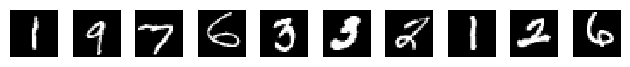

generated


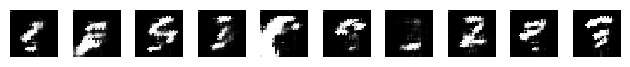

epoch 6505: [time: 270.42436599731445 ms]
epoch 6510: [time: 282.8707695007324 ms]
epoch 6515: [time: 297.3647117614746 ms]
epoch 6520: [time: 268.7532901763916 ms]
epoch 6525: [time: 283.9798927307129 ms]
epoch 6530: [time: 257.38024711608887 ms]
epoch 6535: [time: 257.37833976745605 ms]
epoch 6540: [time: 270.44057846069336 ms]
epoch 6545: [time: 266.70241355895996 ms]
epoch 6550: [time: 270.45321464538574 ms]
epoch 6555: [time: 271.9554901123047 ms]
epoch 6560: [time: 290.25888442993164 ms]
epoch 6565: [time: 260.772705078125 ms]
epoch 6570: [time: 264.4345760345459 ms]
epoch 6575: [time: 274.20973777770996 ms]
epoch 6580: [time: 258.0833435058594 ms]
epoch 6585: [time: 284.71851348876953 ms]
epoch 6590: [time: 271.15511894226074 ms]
epoch 6595: [time: 288.1166934967041 ms]
epoch 6600: [time: 271.38423919677734 ms]
[D loss: 13.526891946792603 | acc: 53.125] [G loss: 7.123085975646973]
real


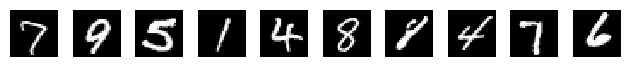

generated


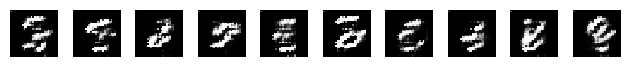

epoch 6605: [time: 270.9791660308838 ms]
epoch 6610: [time: 269.9437141418457 ms]
epoch 6615: [time: 412.15968132019043 ms]
epoch 6620: [time: 291.52703285217285 ms]
epoch 6625: [time: 273.27704429626465 ms]
epoch 6630: [time: 264.268159866333 ms]
epoch 6635: [time: 254.0874481201172 ms]
epoch 6640: [time: 272.1586227416992 ms]
epoch 6645: [time: 266.8600082397461 ms]
epoch 6650: [time: 404.03175354003906 ms]
epoch 6655: [time: 275.0246524810791 ms]
epoch 6660: [time: 278.9185047149658 ms]
epoch 6665: [time: 263.37695121765137 ms]
epoch 6670: [time: 452.3472785949707 ms]
epoch 6675: [time: 271.9883918762207 ms]
epoch 6680: [time: 272.5052833557129 ms]
epoch 6685: [time: 747.7037906646729 ms]
epoch 6690: [time: 295.2759265899658 ms]
epoch 6695: [time: 278.66673469543457 ms]
epoch 6700: [time: 283.16736221313477 ms]
[D loss: 14.50561273097992 | acc: 46.875] [G loss: 11.274581909179688]
real


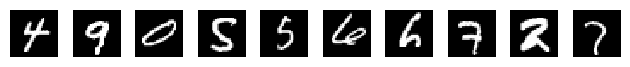

generated


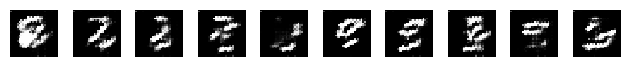

epoch 6705: [time: 269.7930335998535 ms]
epoch 6710: [time: 280.4896831512451 ms]
epoch 6715: [time: 296.99158668518066 ms]
epoch 6720: [time: 284.3310832977295 ms]
epoch 6725: [time: 283.8716506958008 ms]
epoch 6730: [time: 277.0538330078125 ms]
epoch 6735: [time: 285.60829162597656 ms]
epoch 6740: [time: 269.4664001464844 ms]
epoch 6745: [time: 263.0496025085449 ms]
epoch 6750: [time: 272.17817306518555 ms]
epoch 6755: [time: 280.4107666015625 ms]
epoch 6760: [time: 272.61924743652344 ms]
epoch 6765: [time: 272.9005813598633 ms]
epoch 6770: [time: 298.04539680480957 ms]
epoch 6775: [time: 278.1221866607666 ms]
epoch 6780: [time: 285.2966785430908 ms]
epoch 6785: [time: 281.6619873046875 ms]
epoch 6790: [time: 283.308744430542 ms]
epoch 6795: [time: 291.1534309387207 ms]
epoch 6800: [time: 279.0801525115967 ms]
[D loss: 15.203151822090149 | acc: 50.78125] [G loss: 12.270844459533691]
real


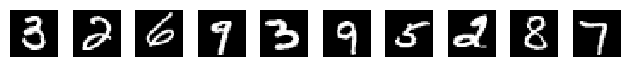

generated


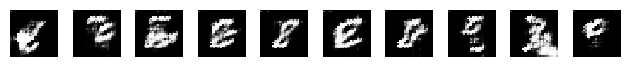

epoch 6805: [time: 268.7218189239502 ms]
epoch 6810: [time: 276.79991722106934 ms]
epoch 6815: [time: 263.9622688293457 ms]
epoch 6820: [time: 260.93459129333496 ms]
epoch 6825: [time: 278.8662910461426 ms]
epoch 6830: [time: 273.64277839660645 ms]
epoch 6835: [time: 271.35753631591797 ms]
epoch 6840: [time: 276.0651111602783 ms]
epoch 6845: [time: 265.14148712158203 ms]
epoch 6850: [time: 284.93380546569824 ms]
epoch 6855: [time: 268.13340187072754 ms]
epoch 6860: [time: 301.1178970336914 ms]
epoch 6865: [time: 271.79670333862305 ms]
epoch 6870: [time: 279.5569896697998 ms]
epoch 6875: [time: 318.79305839538574 ms]
epoch 6880: [time: 273.4200954437256 ms]
epoch 6885: [time: 271.58403396606445 ms]
epoch 6890: [time: 270.8005905151367 ms]
epoch 6895: [time: 284.0542793273926 ms]
epoch 6900: [time: 263.72766494750977 ms]
[D loss: 12.098189949989319 | acc: 54.6875] [G loss: 12.17138671875]
real


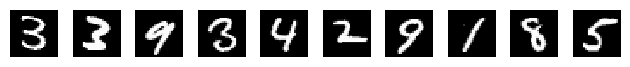

generated


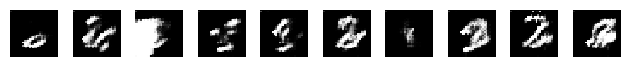

epoch 6905: [time: 274.94001388549805 ms]
epoch 6910: [time: 276.4875888824463 ms]
epoch 6915: [time: 281.3096046447754 ms]
epoch 6920: [time: 277.48584747314453 ms]
epoch 6925: [time: 285.6936454772949 ms]
epoch 6930: [time: 278.2104015350342 ms]
epoch 6935: [time: 288.6538505554199 ms]
epoch 6940: [time: 282.5000286102295 ms]
epoch 6945: [time: 275.3152847290039 ms]
epoch 6950: [time: 268.1918144226074 ms]
epoch 6955: [time: 285.4266166687012 ms]
epoch 6960: [time: 277.4534225463867 ms]
epoch 6965: [time: 275.8321762084961 ms]
epoch 6970: [time: 291.1417484283447 ms]
epoch 6975: [time: 280.3606986999512 ms]
epoch 6980: [time: 268.8872814178467 ms]
epoch 6985: [time: 289.5238399505615 ms]
epoch 6990: [time: 294.7671413421631 ms]
epoch 6995: [time: 305.1307201385498 ms]
epoch 7000: [time: 278.8679599761963 ms]
[D loss: 11.84773874282837 | acc: 57.8125] [G loss: 8.97152328491211]
real


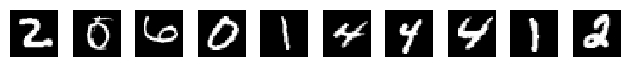

generated


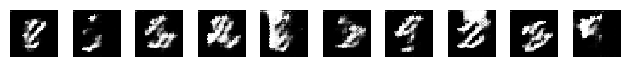

epoch 7005: [time: 273.8819122314453 ms]
epoch 7010: [time: 272.505521774292 ms]
epoch 7015: [time: 287.01043128967285 ms]
epoch 7020: [time: 263.23914527893066 ms]
epoch 7025: [time: 425.001859664917 ms]
epoch 7030: [time: 272.1841335296631 ms]
epoch 7035: [time: 296.0662841796875 ms]
epoch 7040: [time: 268.41068267822266 ms]
epoch 7045: [time: 291.70894622802734 ms]
epoch 7050: [time: 283.10489654541016 ms]
epoch 7055: [time: 273.1297016143799 ms]
epoch 7060: [time: 393.8908576965332 ms]
epoch 7065: [time: 273.0519771575928 ms]
epoch 7070: [time: 279.85262870788574 ms]
epoch 7075: [time: 264.1746997833252 ms]
epoch 7080: [time: 280.4720401763916 ms]
epoch 7085: [time: 300.57525634765625 ms]
epoch 7090: [time: 280.52520751953125 ms]
epoch 7095: [time: 413.03300857543945 ms]
epoch 7100: [time: 273.8640308380127 ms]
[D loss: 16.594247341156006 | acc: 50.0] [G loss: 7.941511154174805]
real


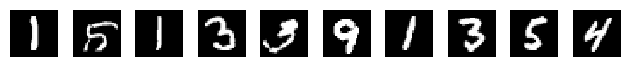

generated


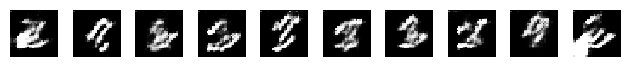

epoch 7105: [time: 267.5909996032715 ms]
epoch 7110: [time: 297.50585556030273 ms]
epoch 7115: [time: 272.0141410827637 ms]
epoch 7120: [time: 264.22595977783203 ms]
epoch 7125: [time: 274.3985652923584 ms]
epoch 7130: [time: 374.88746643066406 ms]
epoch 7135: [time: 279.34956550598145 ms]
epoch 7140: [time: 276.98826789855957 ms]
epoch 7145: [time: 264.74785804748535 ms]
epoch 7150: [time: 273.63133430480957 ms]
epoch 7155: [time: 262.9354000091553 ms]
epoch 7160: [time: 286.47422790527344 ms]
epoch 7165: [time: 382.39407539367676 ms]
epoch 7170: [time: 260.51902770996094 ms]
epoch 7175: [time: 269.65832710266113 ms]
epoch 7180: [time: 269.93823051452637 ms]
epoch 7185: [time: 254.2266845703125 ms]
epoch 7190: [time: 277.28986740112305 ms]
epoch 7195: [time: 277.50086784362793 ms]
epoch 7200: [time: 286.1030101776123 ms]
[D loss: 15.450721621513367 | acc: 60.15625] [G loss: 9.020357131958008]
real


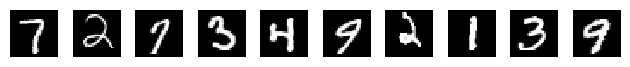

generated


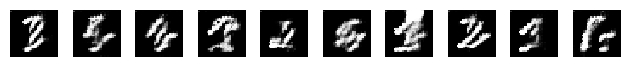

epoch 7205: [time: 284.20066833496094 ms]
epoch 7210: [time: 277.9572010040283 ms]
epoch 7215: [time: 290.12131690979004 ms]
epoch 7220: [time: 306.72502517700195 ms]
epoch 7225: [time: 284.06262397766113 ms]
epoch 7230: [time: 387.36701011657715 ms]
epoch 7235: [time: 288.8360023498535 ms]
epoch 7240: [time: 284.2237949371338 ms]
epoch 7245: [time: 280.26747703552246 ms]
epoch 7250: [time: 278.7516117095947 ms]
epoch 7255: [time: 277.172327041626 ms]
epoch 7260: [time: 312.44468688964844 ms]
epoch 7265: [time: 278.3544063568115 ms]
epoch 7270: [time: 260.8363628387451 ms]
epoch 7275: [time: 276.19457244873047 ms]
epoch 7280: [time: 286.7717742919922 ms]
epoch 7285: [time: 262.16864585876465 ms]
epoch 7290: [time: 353.1179428100586 ms]
epoch 7295: [time: 295.5000400543213 ms]
epoch 7300: [time: 274.17969703674316 ms]
[D loss: 12.722248196601868 | acc: 50.0] [G loss: 8.266460418701172]
real


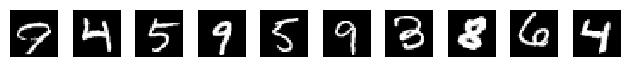

generated


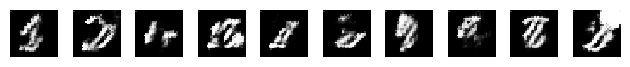

epoch 7305: [time: 276.1404514312744 ms]
epoch 7310: [time: 282.2234630584717 ms]
epoch 7315: [time: 270.01214027404785 ms]
epoch 7320: [time: 268.53036880493164 ms]
epoch 7325: [time: 295.14622688293457 ms]
epoch 7330: [time: 272.4490165710449 ms]
epoch 7335: [time: 413.41543197631836 ms]
epoch 7340: [time: 282.3019027709961 ms]
epoch 7345: [time: 273.9737033843994 ms]
epoch 7350: [time: 272.9024887084961 ms]
epoch 7355: [time: 275.5262851715088 ms]
epoch 7360: [time: 272.5348472595215 ms]
epoch 7365: [time: 280.0750732421875 ms]
epoch 7370: [time: 268.74279975891113 ms]
epoch 7375: [time: 292.0362949371338 ms]
epoch 7380: [time: 272.3400592803955 ms]
epoch 7385: [time: 276.6761779785156 ms]
epoch 7390: [time: 271.21949195861816 ms]
epoch 7395: [time: 275.9103775024414 ms]
epoch 7400: [time: 280.9278964996338 ms]
[D loss: 11.14756977558136 | acc: 62.5] [G loss: 10.506831169128418]
real


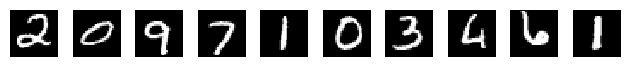

generated


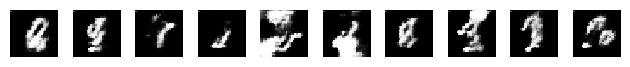

epoch 7405: [time: 279.1891098022461 ms]
epoch 7410: [time: 274.92237091064453 ms]
epoch 7415: [time: 285.3829860687256 ms]
epoch 7420: [time: 263.64803314208984 ms]
epoch 7425: [time: 276.89552307128906 ms]
epoch 7430: [time: 272.51315116882324 ms]
epoch 7435: [time: 264.019250869751 ms]
epoch 7440: [time: 282.2585105895996 ms]
epoch 7445: [time: 276.409387588501 ms]
epoch 7450: [time: 283.59317779541016 ms]
epoch 7455: [time: 279.35051918029785 ms]
epoch 7460: [time: 289.7961139678955 ms]
epoch 7465: [time: 291.40186309814453 ms]
epoch 7470: [time: 261.94214820861816 ms]
epoch 7475: [time: 298.57563972473145 ms]
epoch 7480: [time: 289.4177436828613 ms]
epoch 7485: [time: 299.51000213623047 ms]
epoch 7490: [time: 287.6880168914795 ms]
epoch 7495: [time: 286.94772720336914 ms]
epoch 7500: [time: 266.2672996520996 ms]
[D loss: 15.131731510162354 | acc: 52.34375] [G loss: 12.93245792388916]
real


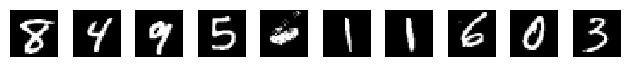

generated


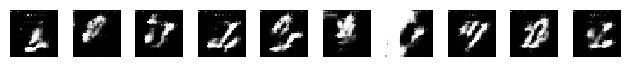

epoch 7505: [time: 401.5169143676758 ms]
epoch 7510: [time: 266.6618824005127 ms]
epoch 7515: [time: 270.97415924072266 ms]
epoch 7520: [time: 284.3284606933594 ms]
epoch 7525: [time: 273.37098121643066 ms]
epoch 7530: [time: 269.0777778625488 ms]
epoch 7535: [time: 276.45039558410645 ms]
epoch 7540: [time: 410.067081451416 ms]
epoch 7545: [time: 269.5028781890869 ms]
epoch 7550: [time: 257.2338581085205 ms]
epoch 7555: [time: 295.52769660949707 ms]
epoch 7560: [time: 274.4579315185547 ms]
epoch 7565: [time: 269.90485191345215 ms]
epoch 7570: [time: 270.48611640930176 ms]
epoch 7575: [time: 414.3557548522949 ms]
epoch 7580: [time: 263.4878158569336 ms]
epoch 7585: [time: 272.54652976989746 ms]
epoch 7590: [time: 267.1225070953369 ms]
epoch 7595: [time: 289.51406478881836 ms]
epoch 7600: [time: 259.44066047668457 ms]
[D loss: 13.080496788024902 | acc: 53.90625] [G loss: 7.619540214538574]
real


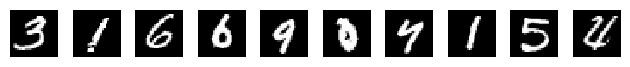

generated


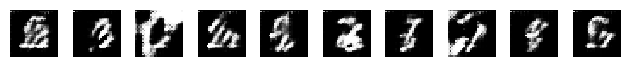

epoch 7605: [time: 279.30188179016113 ms]
epoch 7610: [time: 407.015323638916 ms]
epoch 7615: [time: 276.40819549560547 ms]
epoch 7620: [time: 270.460844039917 ms]
epoch 7625: [time: 272.69983291625977 ms]
epoch 7630: [time: 279.0374755859375 ms]
epoch 7635: [time: 269.78325843811035 ms]
epoch 7640: [time: 277.66919136047363 ms]
epoch 7645: [time: 382.9183578491211 ms]
epoch 7650: [time: 269.09923553466797 ms]
epoch 7655: [time: 255.19275665283203 ms]
epoch 7660: [time: 266.65210723876953 ms]
epoch 7665: [time: 274.62220191955566 ms]
epoch 7670: [time: 286.32402420043945 ms]
epoch 7675: [time: 282.1002006530762 ms]
epoch 7680: [time: 400.6333351135254 ms]
epoch 7685: [time: 270.2646255493164 ms]
epoch 7690: [time: 273.10681343078613 ms]
epoch 7695: [time: 278.1801223754883 ms]
epoch 7700: [time: 270.5509662628174 ms]
[D loss: 11.832490086555481 | acc: 53.125] [G loss: 7.910564422607422]
real


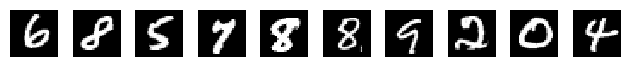

generated


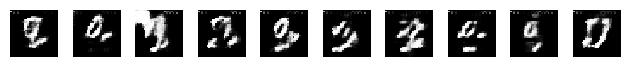

epoch 7705: [time: 282.2837829589844 ms]
epoch 7710: [time: 302.5496006011963 ms]
epoch 7715: [time: 270.9057331085205 ms]
epoch 7720: [time: 270.40696144104004 ms]
epoch 7725: [time: 273.6217975616455 ms]
epoch 7730: [time: 303.7540912628174 ms]
epoch 7735: [time: 275.0697135925293 ms]
epoch 7740: [time: 278.8281440734863 ms]
epoch 7745: [time: 276.8270969390869 ms]
epoch 7750: [time: 289.38770294189453 ms]
epoch 7755: [time: 291.7459011077881 ms]
epoch 7760: [time: 272.56178855895996 ms]
epoch 7765: [time: 302.398681640625 ms]
epoch 7770: [time: 268.94378662109375 ms]
epoch 7775: [time: 278.789758682251 ms]
epoch 7780: [time: 277.6663303375244 ms]
epoch 7785: [time: 293.3659553527832 ms]
epoch 7790: [time: 269.2122459411621 ms]
epoch 7795: [time: 284.0301990509033 ms]
epoch 7800: [time: 275.65932273864746 ms]
[D loss: 15.170108556747437 | acc: 53.90625] [G loss: 8.154916763305664]
real


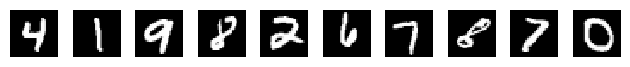

generated


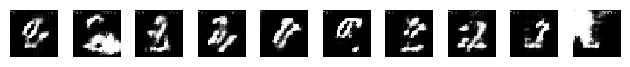

epoch 7805: [time: 307.61003494262695 ms]
epoch 7810: [time: 277.33707427978516 ms]
epoch 7815: [time: 303.2875061035156 ms]
epoch 7820: [time: 301.9981384277344 ms]
epoch 7825: [time: 279.21342849731445 ms]
epoch 7830: [time: 289.40677642822266 ms]
epoch 7835: [time: 278.2454490661621 ms]
epoch 7840: [time: 263.0598545074463 ms]
epoch 7845: [time: 254.90140914916992 ms]
epoch 7850: [time: 284.0590476989746 ms]
epoch 7855: [time: 278.63407135009766 ms]
epoch 7860: [time: 285.7551574707031 ms]
epoch 7865: [time: 264.5385265350342 ms]
epoch 7870: [time: 270.7037925720215 ms]
epoch 7875: [time: 276.97134017944336 ms]
epoch 7880: [time: 256.1304569244385 ms]
epoch 7885: [time: 281.0373306274414 ms]
epoch 7890: [time: 265.9928798675537 ms]
epoch 7895: [time: 268.34678649902344 ms]
epoch 7900: [time: 285.42304039001465 ms]
[D loss: 11.276401162147522 | acc: 54.6875] [G loss: 8.203340530395508]
real


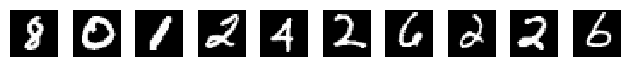

generated


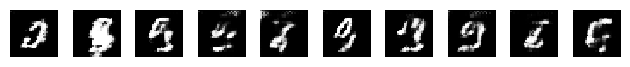

epoch 7905: [time: 277.2819995880127 ms]
epoch 7910: [time: 268.9523696899414 ms]
epoch 7915: [time: 272.0062732696533 ms]
epoch 7920: [time: 313.7969970703125 ms]
epoch 7925: [time: 284.895658493042 ms]
epoch 7930: [time: 258.8481903076172 ms]
epoch 7935: [time: 287.2006893157959 ms]
epoch 7940: [time: 268.5363292694092 ms]
epoch 7945: [time: 269.9604034423828 ms]
epoch 7950: [time: 266.4363384246826 ms]
epoch 7955: [time: 273.93388748168945 ms]
epoch 7960: [time: 273.26297760009766 ms]
epoch 7965: [time: 272.83620834350586 ms]
epoch 7970: [time: 272.1536159515381 ms]
epoch 7975: [time: 270.2207565307617 ms]
epoch 7980: [time: 277.6508331298828 ms]
epoch 7985: [time: 274.2178440093994 ms]
epoch 7990: [time: 296.37742042541504 ms]
epoch 7995: [time: 281.53300285339355 ms]
epoch 8000: [time: 267.0114040374756 ms]
[D loss: 14.254950761795044 | acc: 50.78125] [G loss: 7.1968207359313965]
real


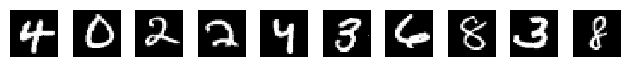

generated


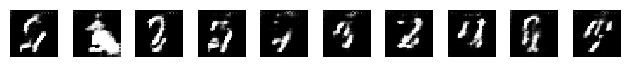

epoch 8005: [time: 277.90284156799316 ms]
epoch 8010: [time: 275.4015922546387 ms]
epoch 8015: [time: 289.95251655578613 ms]
epoch 8020: [time: 284.5876216888428 ms]
epoch 8025: [time: 289.7148132324219 ms]
epoch 8030: [time: 278.9478302001953 ms]
epoch 8035: [time: 281.5284729003906 ms]
epoch 8040: [time: 272.9780673980713 ms]
epoch 8045: [time: 279.0658473968506 ms]
epoch 8050: [time: 277.96196937561035 ms]
epoch 8055: [time: 386.4006996154785 ms]
epoch 8060: [time: 276.0183811187744 ms]
epoch 8065: [time: 267.8723335266113 ms]
epoch 8070: [time: 277.24623680114746 ms]
epoch 8075: [time: 272.2439765930176 ms]
epoch 8080: [time: 269.0598964691162 ms]
epoch 8085: [time: 283.61058235168457 ms]
epoch 8090: [time: 376.6813278198242 ms]
epoch 8095: [time: 292.9377555847168 ms]
epoch 8100: [time: 269.47903633117676 ms]
[D loss: 13.547446012496948 | acc: 56.25] [G loss: 9.242706298828125]
real


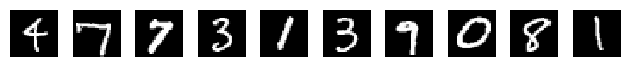

generated


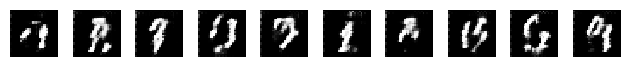

epoch 8105: [time: 271.6798782348633 ms]
epoch 8110: [time: 277.4200439453125 ms]
epoch 8115: [time: 255.99002838134766 ms]
epoch 8120: [time: 255.4762363433838 ms]
epoch 8125: [time: 278.1038284301758 ms]
epoch 8130: [time: 329.8373222351074 ms]
epoch 8135: [time: 278.77354621887207 ms]
epoch 8140: [time: 271.66175842285156 ms]
epoch 8145: [time: 267.2607898712158 ms]
epoch 8150: [time: 275.3148078918457 ms]
epoch 8155: [time: 253.44228744506836 ms]
epoch 8160: [time: 275.5591869354248 ms]
epoch 8165: [time: 264.28866386413574 ms]
epoch 8170: [time: 293.31040382385254 ms]
epoch 8175: [time: 275.47264099121094 ms]
epoch 8180: [time: 279.9351215362549 ms]
epoch 8185: [time: 279.74534034729004 ms]
epoch 8190: [time: 265.26784896850586 ms]
epoch 8195: [time: 292.9577827453613 ms]
epoch 8200: [time: 271.7783451080322 ms]
[D loss: 14.780647158622742 | acc: 54.6875] [G loss: 9.613816261291504]
real


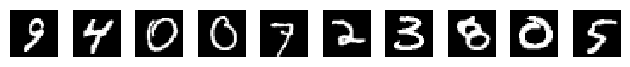

generated


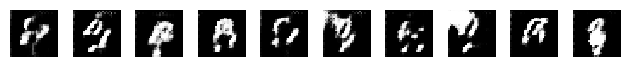

epoch 8205: [time: 279.12259101867676 ms]
epoch 8210: [time: 286.14068031311035 ms]
epoch 8215: [time: 275.83765983581543 ms]
epoch 8220: [time: 276.7486572265625 ms]
epoch 8225: [time: 288.6171340942383 ms]
epoch 8230: [time: 286.06438636779785 ms]
epoch 8235: [time: 297.3196506500244 ms]
epoch 8240: [time: 280.23386001586914 ms]
epoch 8245: [time: 296.431303024292 ms]
epoch 8250: [time: 276.22342109680176 ms]
epoch 8255: [time: 293.9116954803467 ms]
epoch 8260: [time: 295.896053314209 ms]
epoch 8265: [time: 294.95739936828613 ms]
epoch 8270: [time: 282.1180820465088 ms]
epoch 8275: [time: 290.79580307006836 ms]
epoch 8280: [time: 267.5907611846924 ms]
epoch 8285: [time: 285.663366317749 ms]
epoch 8290: [time: 298.1569766998291 ms]
epoch 8295: [time: 302.9348850250244 ms]
epoch 8300: [time: 291.6715145111084 ms]
[D loss: 13.65727561712265 | acc: 53.90625] [G loss: 10.515745162963867]
real


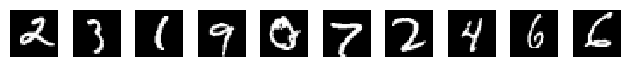

generated


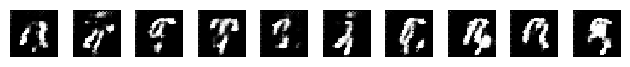

epoch 8305: [time: 272.0818519592285 ms]
epoch 8310: [time: 271.8219757080078 ms]
epoch 8315: [time: 273.72217178344727 ms]
epoch 8320: [time: 268.8436508178711 ms]
epoch 8325: [time: 281.1610698699951 ms]
epoch 8330: [time: 279.5453071594238 ms]
epoch 8335: [time: 325.4406452178955 ms]
epoch 8340: [time: 282.46045112609863 ms]
epoch 8345: [time: 286.23008728027344 ms]
epoch 8350: [time: 279.0985107421875 ms]
epoch 8355: [time: 270.0161933898926 ms]
epoch 8360: [time: 283.41102600097656 ms]
epoch 8365: [time: 283.71310234069824 ms]
epoch 8370: [time: 279.39867973327637 ms]
epoch 8375: [time: 280.86233139038086 ms]
epoch 8380: [time: 275.1774787902832 ms]
epoch 8385: [time: 272.4132537841797 ms]
epoch 8390: [time: 268.65649223327637 ms]
epoch 8395: [time: 288.5448932647705 ms]
epoch 8400: [time: 282.18579292297363 ms]
[D loss: 14.88275671005249 | acc: 53.90625] [G loss: 9.944055557250977]
real


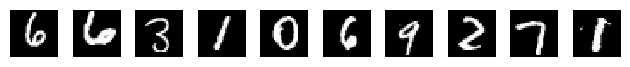

generated


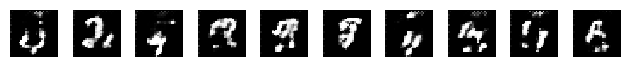

epoch 8405: [time: 268.9673900604248 ms]
epoch 8410: [time: 277.47130393981934 ms]
epoch 8415: [time: 276.94249153137207 ms]
epoch 8420: [time: 284.6071720123291 ms]
epoch 8425: [time: 288.3467674255371 ms]
epoch 8430: [time: 260.44654846191406 ms]
epoch 8435: [time: 298.231840133667 ms]
epoch 8440: [time: 284.98125076293945 ms]
epoch 8445: [time: 286.2677574157715 ms]
epoch 8450: [time: 279.24323081970215 ms]
epoch 8455: [time: 293.1663990020752 ms]
epoch 8460: [time: 282.5906276702881 ms]
epoch 8465: [time: 265.96999168395996 ms]
epoch 8470: [time: 412.5649929046631 ms]
epoch 8475: [time: 270.3995704650879 ms]
epoch 8480: [time: 292.0823097229004 ms]
epoch 8485: [time: 270.188570022583 ms]
epoch 8490: [time: 272.63498306274414 ms]
epoch 8495: [time: 285.2175235748291 ms]
epoch 8500: [time: 266.7734622955322 ms]
[D loss: 14.07853388786316 | acc: 55.46875] [G loss: 10.588776588439941]
real


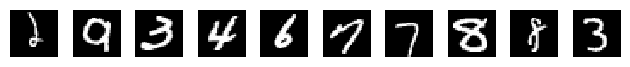

generated


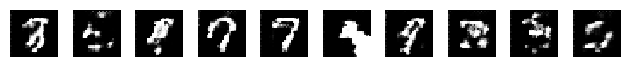

epoch 8505: [time: 300.04429817199707 ms]
epoch 8510: [time: 276.386022567749 ms]
epoch 8515: [time: 282.16099739074707 ms]
epoch 8520: [time: 271.2430953979492 ms]
epoch 8525: [time: 262.6039981842041 ms]
epoch 8530: [time: 260.0672245025635 ms]
epoch 8535: [time: 285.82119941711426 ms]
epoch 8540: [time: 282.69386291503906 ms]
epoch 8545: [time: 278.8848876953125 ms]
epoch 8550: [time: 271.6631889343262 ms]
epoch 8555: [time: 269.4091796875 ms]
epoch 8560: [time: 293.78247261047363 ms]
epoch 8565: [time: 289.1361713409424 ms]
epoch 8570: [time: 399.98412132263184 ms]
epoch 8575: [time: 269.209623336792 ms]
epoch 8580: [time: 263.2877826690674 ms]
epoch 8585: [time: 272.3548412322998 ms]
epoch 8590: [time: 261.04164123535156 ms]
epoch 8595: [time: 277.12345123291016 ms]
epoch 8600: [time: 274.83129501342773 ms]
[D loss: 16.6299809217453 | acc: 52.34375] [G loss: 12.107141494750977]
real


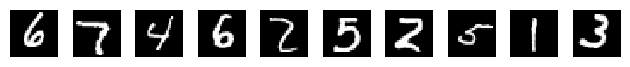

generated


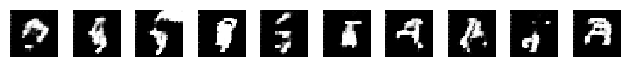

epoch 8605: [time: 269.50907707214355 ms]
epoch 8610: [time: 267.2460079193115 ms]
epoch 8615: [time: 253.52954864501953 ms]
epoch 8620: [time: 254.78291511535645 ms]
epoch 8625: [time: 281.61144256591797 ms]
epoch 8630: [time: 264.38093185424805 ms]
epoch 8635: [time: 282.7169895172119 ms]
epoch 8640: [time: 262.38536834716797 ms]
epoch 8645: [time: 271.6360092163086 ms]
epoch 8650: [time: 266.6277885437012 ms]
epoch 8655: [time: 259.69719886779785 ms]
epoch 8660: [time: 273.23055267333984 ms]
epoch 8665: [time: 280.8701992034912 ms]
epoch 8670: [time: 277.72974967956543 ms]
epoch 8675: [time: 262.2683048248291 ms]
epoch 8680: [time: 267.7638530731201 ms]
epoch 8685: [time: 280.08198738098145 ms]
epoch 8690: [time: 261.1403465270996 ms]
epoch 8695: [time: 259.183406829834 ms]
epoch 8700: [time: 285.1529121398926 ms]
[D loss: 16.534574687480927 | acc: 60.9375] [G loss: 14.434085845947266]
real


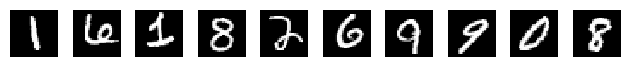

generated


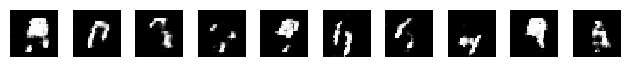

epoch 8705: [time: 264.9083137512207 ms]
epoch 8710: [time: 272.40538597106934 ms]
epoch 8715: [time: 287.1208190917969 ms]
epoch 8720: [time: 275.7401466369629 ms]
epoch 8725: [time: 285.13193130493164 ms]
epoch 8730: [time: 282.99617767333984 ms]
epoch 8735: [time: 258.6820125579834 ms]
epoch 8740: [time: 269.5906162261963 ms]
epoch 8745: [time: 276.292085647583 ms]
epoch 8750: [time: 257.57336616516113 ms]
epoch 8755: [time: 278.456449508667 ms]
epoch 8760: [time: 260.68973541259766 ms]
epoch 8765: [time: 346.31967544555664 ms]
epoch 8770: [time: 280.32374382019043 ms]
epoch 8775: [time: 305.1438331604004 ms]
epoch 8780: [time: 290.50254821777344 ms]
epoch 8785: [time: 285.05444526672363 ms]
epoch 8790: [time: 308.4902763366699 ms]
epoch 8795: [time: 291.58735275268555 ms]
epoch 8800: [time: 287.00995445251465 ms]
[D loss: 17.8787659406662 | acc: 50.0] [G loss: 13.485530853271484]
real


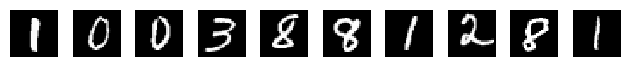

generated


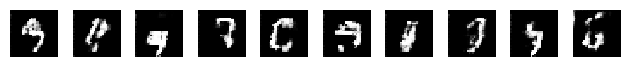

epoch 8805: [time: 274.0030288696289 ms]
epoch 8810: [time: 296.785831451416 ms]
epoch 8815: [time: 267.52471923828125 ms]
epoch 8820: [time: 267.80080795288086 ms]
epoch 8825: [time: 274.63555335998535 ms]
epoch 8830: [time: 264.39762115478516 ms]
epoch 8835: [time: 288.0096435546875 ms]
epoch 8840: [time: 284.7311496734619 ms]
epoch 8845: [time: 275.07543563842773 ms]
epoch 8850: [time: 271.09313011169434 ms]
epoch 8855: [time: 278.23758125305176 ms]
epoch 8860: [time: 293.43485832214355 ms]
epoch 8865: [time: 270.57433128356934 ms]
epoch 8870: [time: 284.90400314331055 ms]
epoch 8875: [time: 292.5560474395752 ms]
epoch 8880: [time: 283.24270248413086 ms]
epoch 8885: [time: 288.2537841796875 ms]
epoch 8890: [time: 282.2580337524414 ms]
epoch 8895: [time: 271.90303802490234 ms]
epoch 8900: [time: 273.547887802124 ms]
[D loss: 18.124938368797302 | acc: 50.0] [G loss: 14.520044326782227]
real


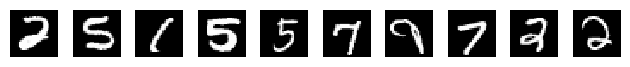

generated


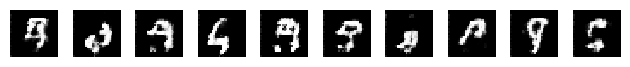

epoch 8905: [time: 269.7927951812744 ms]
epoch 8910: [time: 272.6106643676758 ms]
epoch 8915: [time: 280.88831901550293 ms]
epoch 8920: [time: 278.47838401794434 ms]
epoch 8925: [time: 278.4271240234375 ms]
epoch 8930: [time: 275.9819030761719 ms]
epoch 8935: [time: 298.6431121826172 ms]
epoch 8940: [time: 271.6491222381592 ms]
epoch 8945: [time: 269.9298858642578 ms]
epoch 8950: [time: 298.6102104187012 ms]
epoch 8955: [time: 269.8631286621094 ms]
epoch 8960: [time: 276.1209011077881 ms]
epoch 8965: [time: 265.47813415527344 ms]
epoch 8970: [time: 283.5712432861328 ms]
epoch 8975: [time: 270.7712650299072 ms]
epoch 8980: [time: 282.090425491333 ms]
epoch 8985: [time: 290.71903228759766 ms]
epoch 8990: [time: 286.71765327453613 ms]
epoch 8995: [time: 284.0404510498047 ms]
epoch 9000: [time: 274.94311332702637 ms]
[D loss: 15.430267333984375 | acc: 57.8125] [G loss: 11.277164459228516]
real


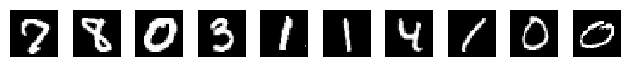

generated


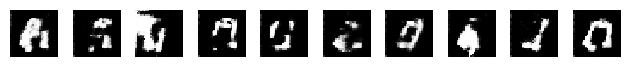

epoch 9005: [time: 293.69592666625977 ms]
epoch 9010: [time: 276.1070728302002 ms]
epoch 9015: [time: 283.71548652648926 ms]
epoch 9020: [time: 272.9341983795166 ms]
epoch 9025: [time: 282.2253704071045 ms]
epoch 9030: [time: 274.60527420043945 ms]
epoch 9035: [time: 284.9736213684082 ms]
epoch 9040: [time: 279.8001766204834 ms]
epoch 9045: [time: 258.5172653198242 ms]
epoch 9050: [time: 295.5048084259033 ms]
epoch 9055: [time: 287.3411178588867 ms]
epoch 9060: [time: 274.9640941619873 ms]
epoch 9065: [time: 280.9889316558838 ms]
epoch 9070: [time: 263.2458209991455 ms]
epoch 9075: [time: 279.5300483703613 ms]
epoch 9080: [time: 274.39332008361816 ms]
epoch 9085: [time: 297.7149486541748 ms]
epoch 9090: [time: 299.6022701263428 ms]
epoch 9095: [time: 282.7603816986084 ms]
epoch 9100: [time: 274.26719665527344 ms]
[D loss: 18.797008514404297 | acc: 51.5625] [G loss: 13.728952407836914]
real


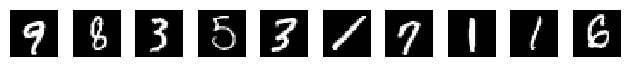

generated


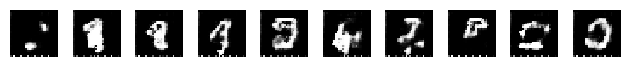

epoch 9105: [time: 276.5007019042969 ms]
epoch 9110: [time: 280.0874710083008 ms]
epoch 9115: [time: 289.081335067749 ms]
epoch 9120: [time: 280.287504196167 ms]
epoch 9125: [time: 270.8239555358887 ms]
epoch 9130: [time: 280.3688049316406 ms]
epoch 9135: [time: 296.5550422668457 ms]
epoch 9140: [time: 258.6984634399414 ms]
epoch 9145: [time: 261.75951957702637 ms]
epoch 9150: [time: 250.89669227600098 ms]
epoch 9155: [time: 268.9197063446045 ms]
epoch 9160: [time: 293.8687801361084 ms]
epoch 9165: [time: 266.4480209350586 ms]
epoch 9170: [time: 284.8653793334961 ms]
epoch 9175: [time: 267.87638664245605 ms]
epoch 9180: [time: 281.2356948852539 ms]
epoch 9185: [time: 266.754150390625 ms]
epoch 9190: [time: 274.8417854309082 ms]
epoch 9195: [time: 289.1414165496826 ms]
epoch 9200: [time: 268.74828338623047 ms]
[D loss: 16.91666030883789 | acc: 59.375] [G loss: 14.504922866821289]
real


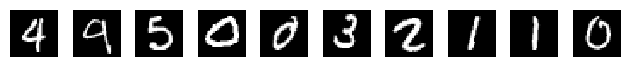

generated


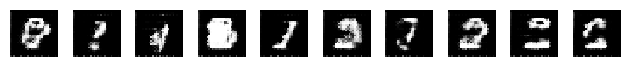

epoch 9205: [time: 270.43628692626953 ms]
epoch 9210: [time: 264.47224617004395 ms]
epoch 9215: [time: 277.5893211364746 ms]
epoch 9220: [time: 261.641263961792 ms]
epoch 9225: [time: 281.3847064971924 ms]
epoch 9230: [time: 270.97272872924805 ms]
epoch 9235: [time: 274.9764919281006 ms]
epoch 9240: [time: 270.5810070037842 ms]
epoch 9245: [time: 269.3617343902588 ms]
epoch 9250: [time: 276.9174575805664 ms]
epoch 9255: [time: 276.08609199523926 ms]
epoch 9260: [time: 282.1085453033447 ms]
epoch 9265: [time: 270.5249786376953 ms]
epoch 9270: [time: 265.2733325958252 ms]
epoch 9275: [time: 282.2272777557373 ms]
epoch 9280: [time: 276.5069007873535 ms]
epoch 9285: [time: 275.8941650390625 ms]
epoch 9290: [time: 273.2093334197998 ms]
epoch 9295: [time: 284.2109203338623 ms]
epoch 9300: [time: 268.2459354400635 ms]
[D loss: 22.413291931152344 | acc: 48.4375] [G loss: 9.435163497924805]
real


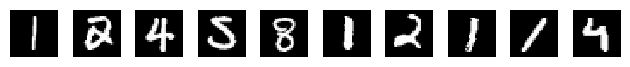

generated


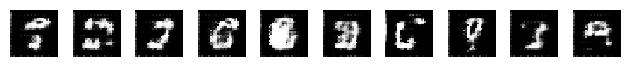

epoch 9305: [time: 279.42752838134766 ms]
epoch 9310: [time: 290.6842231750488 ms]
epoch 9315: [time: 277.79507637023926 ms]
epoch 9320: [time: 268.04327964782715 ms]
epoch 9325: [time: 285.2210998535156 ms]
epoch 9330: [time: 281.5568447113037 ms]
epoch 9335: [time: 300.92906951904297 ms]
epoch 9340: [time: 277.4806022644043 ms]
epoch 9345: [time: 285.322904586792 ms]
epoch 9350: [time: 287.2030735015869 ms]
epoch 9355: [time: 285.72630882263184 ms]
epoch 9360: [time: 321.7747211456299 ms]
epoch 9365: [time: 276.92270278930664 ms]
epoch 9370: [time: 273.6978530883789 ms]
epoch 9375: [time: 282.74989128112793 ms]
epoch 9380: [time: 277.6784896850586 ms]
epoch 9385: [time: 282.0770740509033 ms]
epoch 9390: [time: 275.04611015319824 ms]
epoch 9395: [time: 294.85511779785156 ms]
epoch 9400: [time: 270.6334590911865 ms]
[D loss: 23.54317045211792 | acc: 47.65625] [G loss: 18.17364501953125]
real


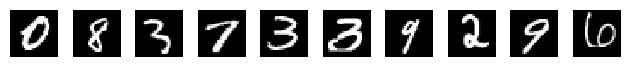

generated


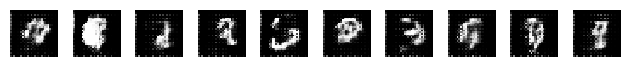

epoch 9405: [time: 271.47889137268066 ms]
epoch 9410: [time: 282.9875946044922 ms]
epoch 9415: [time: 270.55954933166504 ms]
epoch 9420: [time: 279.6328067779541 ms]
epoch 9425: [time: 267.86112785339355 ms]
epoch 9430: [time: 277.5144577026367 ms]
epoch 9435: [time: 301.8674850463867 ms]
epoch 9440: [time: 289.22057151794434 ms]
epoch 9445: [time: 283.2958698272705 ms]
epoch 9450: [time: 285.11691093444824 ms]
epoch 9455: [time: 272.39322662353516 ms]
epoch 9460: [time: 264.5885944366455 ms]
epoch 9465: [time: 285.4883670806885 ms]
epoch 9470: [time: 286.9701385498047 ms]
epoch 9475: [time: 273.94747734069824 ms]
epoch 9480: [time: 269.1645622253418 ms]
epoch 9485: [time: 285.9535217285156 ms]
epoch 9490: [time: 290.2071475982666 ms]
epoch 9495: [time: 294.0638065338135 ms]
epoch 9500: [time: 283.9617729187012 ms]
[D loss: 22.00621736049652 | acc: 59.375] [G loss: 14.246561050415039]
real


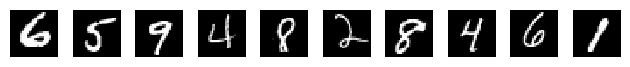

generated


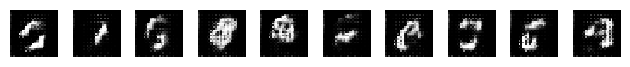

epoch 9505: [time: 292.6294803619385 ms]
epoch 9510: [time: 275.3002643585205 ms]
epoch 9515: [time: 307.0693016052246 ms]
epoch 9520: [time: 287.4934673309326 ms]
epoch 9525: [time: 288.118839263916 ms]
epoch 9530: [time: 296.00024223327637 ms]
epoch 9535: [time: 282.3512554168701 ms]
epoch 9540: [time: 288.593053817749 ms]
epoch 9545: [time: 271.8791961669922 ms]
epoch 9550: [time: 285.1395606994629 ms]
epoch 9555: [time: 284.1341495513916 ms]
epoch 9560: [time: 284.3022346496582 ms]
epoch 9565: [time: 288.7756824493408 ms]
epoch 9570: [time: 264.16587829589844 ms]
epoch 9575: [time: 272.22347259521484 ms]
epoch 9580: [time: 272.63426780700684 ms]
epoch 9585: [time: 292.26064682006836 ms]
epoch 9590: [time: 283.89549255371094 ms]
epoch 9595: [time: 296.0994243621826 ms]
epoch 9600: [time: 312.03746795654297 ms]
[D loss: 26.61580193042755 | acc: 53.125] [G loss: 12.132655143737793]
real


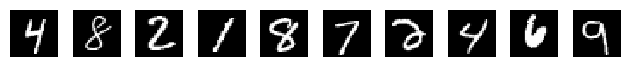

generated


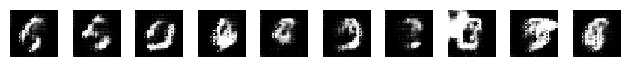

epoch 9605: [time: 285.31408309936523 ms]
epoch 9610: [time: 266.4628028869629 ms]
epoch 9615: [time: 273.11086654663086 ms]
epoch 9620: [time: 274.45125579833984 ms]
epoch 9625: [time: 296.94342613220215 ms]
epoch 9630: [time: 274.212121963501 ms]
epoch 9635: [time: 278.3925533294678 ms]
epoch 9640: [time: 284.70540046691895 ms]
epoch 9645: [time: 276.3547897338867 ms]
epoch 9650: [time: 279.9348831176758 ms]
epoch 9655: [time: 269.4568634033203 ms]
epoch 9660: [time: 284.1916084289551 ms]
epoch 9665: [time: 265.21992683410645 ms]
epoch 9670: [time: 285.48145294189453 ms]
epoch 9675: [time: 281.33344650268555 ms]
epoch 9680: [time: 272.0532417297363 ms]
epoch 9685: [time: 301.347017288208 ms]
epoch 9690: [time: 264.7531032562256 ms]
epoch 9695: [time: 264.2061710357666 ms]
epoch 9700: [time: 271.49367332458496 ms]
[D loss: 23.192110061645508 | acc: 55.46875] [G loss: 18.120309829711914]
real


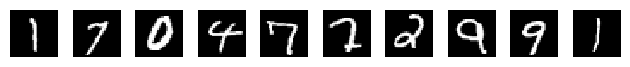

generated


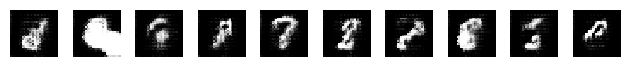

epoch 9705: [time: 265.7332420349121 ms]
epoch 9710: [time: 270.01023292541504 ms]
epoch 9715: [time: 269.0279483795166 ms]
epoch 9720: [time: 282.43041038513184 ms]
epoch 9725: [time: 279.6311378479004 ms]
epoch 9730: [time: 277.47225761413574 ms]
epoch 9735: [time: 267.37165451049805 ms]
epoch 9740: [time: 280.8489799499512 ms]
epoch 9745: [time: 271.0721492767334 ms]
epoch 9750: [time: 312.7305507659912 ms]
epoch 9755: [time: 289.9320125579834 ms]
epoch 9760: [time: 291.8558120727539 ms]
epoch 9765: [time: 261.86227798461914 ms]
epoch 9770: [time: 266.19553565979004 ms]
epoch 9775: [time: 282.4697494506836 ms]
epoch 9780: [time: 280.99632263183594 ms]
epoch 9785: [time: 262.5107765197754 ms]
epoch 9790: [time: 271.86131477355957 ms]
epoch 9795: [time: 270.94411849975586 ms]
epoch 9800: [time: 318.74632835388184 ms]
[D loss: 29.210198402404785 | acc: 47.65625] [G loss: 14.932114601135254]
real


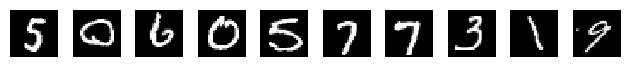

generated


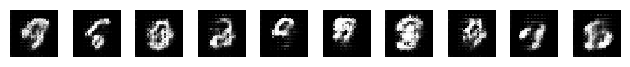

epoch 9805: [time: 280.3025245666504 ms]
epoch 9810: [time: 282.0892333984375 ms]
epoch 9815: [time: 288.13886642456055 ms]
epoch 9820: [time: 276.28087997436523 ms]
epoch 9825: [time: 302.5522232055664 ms]
epoch 9830: [time: 267.5662040710449 ms]
epoch 9835: [time: 277.2486209869385 ms]
epoch 9840: [time: 294.9953079223633 ms]
epoch 9845: [time: 262.8190517425537 ms]
epoch 9850: [time: 279.4036865234375 ms]
epoch 9855: [time: 280.5359363555908 ms]
epoch 9860: [time: 303.99608612060547 ms]
epoch 9865: [time: 270.9364891052246 ms]
epoch 9870: [time: 267.3649787902832 ms]
epoch 9875: [time: 294.7995662689209 ms]
epoch 9880: [time: 274.7235298156738 ms]
epoch 9885: [time: 277.56428718566895 ms]
epoch 9890: [time: 271.9864845275879 ms]
epoch 9895: [time: 293.2114601135254 ms]
epoch 9900: [time: 291.48149490356445 ms]
[D loss: 21.717395782470703 | acc: 59.375] [G loss: 14.995651245117188]
real


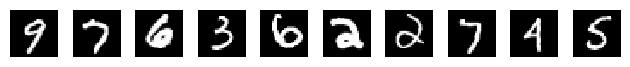

generated


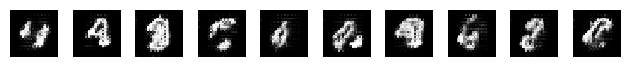

epoch 9905: [time: 268.4469223022461 ms]
epoch 9910: [time: 277.1921157836914 ms]
epoch 9915: [time: 282.35435485839844 ms]
epoch 9920: [time: 285.3386402130127 ms]
epoch 9925: [time: 283.31708908081055 ms]
epoch 9930: [time: 268.7244415283203 ms]
epoch 9935: [time: 260.3893280029297 ms]
epoch 9940: [time: 266.8180465698242 ms]
epoch 9945: [time: 278.0802249908447 ms]
epoch 9950: [time: 276.0789394378662 ms]
epoch 9955: [time: 274.17659759521484 ms]
epoch 9960: [time: 284.2140197753906 ms]
epoch 9965: [time: 277.4667739868164 ms]
epoch 9970: [time: 273.12397956848145 ms]
epoch 9975: [time: 278.1848907470703 ms]
epoch 9980: [time: 280.3499698638916 ms]
epoch 9985: [time: 273.15378189086914 ms]
epoch 9990: [time: 265.50960540771484 ms]
epoch 9995: [time: 264.0373706817627 ms]


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import time
import math

def makeGenerator():
    return Sequential([
        Dense(7 * 7 * 256, input_dim=100),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, 256)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation="tanh")
    ])

def makeDiscriminator():
    return Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(28, 28, 1)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])

def generate_digits(generator, num=10):
    noise = np.random.normal(0, 1, (num, 100))
    return generator.predict(noise, verbose=0)

def plot(images, cols=10):
    images = np.array(images)
    images = np.squeeze(images)  # Remove single channel dimension if present

    num_images = len(images)

    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols) 
    axes = np.array(axes)
    for i in range(rows * cols):
        ax = axes.flat[i]  # Flatten axes for easy access
        if i < num_images:
            ax.imshow(images[i], cmap="gray", interpolation="nearest")
        ax.axis("off")  # Hide axis ticks

    plt.tight_layout()  # Prevent overlapping
    plt.show()

class GAN:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        gan = Sequential([generator, discriminator])
        gan.compile(loss="binary_crossentropy", 
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
        self.gan = gan

    def train(self, X_train, epochs=4000, batch_size=128, latent_dim=100):
        half_batch = batch_size // 2

        for epoch in range(epochs):
            t1 = time.time()

            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            
            fake_imgs = self.generator.predict(noise, verbose=0)

            real_labels = np.ones((half_batch, 1))
            fake_labels = np.zeros((half_batch, 1))

            self.discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            misleading_labels = np.ones((batch_size, 1))

            self.discriminator.trainable = False
            g_loss = self.gan.train_on_batch(noise, misleading_labels)          

            t2 = time.time()

            if epoch % 5 == 0:
                print(f"epoch {epoch}: [time: {(t2-t1) * 1000} ms]")

            # Print progress
            if epoch % 100 == 0:
                print(f"[D loss: {d_loss[0]} | acc: {d_loss[1]*100}] [G loss: {g_loss}]")
                print("real")
                plot(real_imgs[0:10])
                digits = generate_digits(self.generator)
                print(f"generated")
                plot(digits)


if __name__ == '__main__':
    # discriminator model is compiled to allow for training.
    discriminator = makeDiscriminator()
    discriminator.compile(loss="binary_crossentropy", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), metrics=["accuracy"]) 

    # don't compile generator. it is trained as part of the gan.
    generator = makeGenerator()

    (X_train, _), _ = tf.keras.datasets.mnist.load_data()
    X_train = (X_train - 127.5) / 127.5  # Normalize to [-1, 1]
    X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

    gan = GAN(generator, discriminator)
    gan.train(X_train)

